<a href="https://colab.research.google.com/github/OmarAshIbra/8-Assignment/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00


In [ ]:
# Standard library
import math
import random
import json

# Typing
from typing import Optional, Callable, Dict, Tuple, List


# Scientific and data processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.cluster import KMeans
from geopy.distance import geodesic

# Torch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATv2Conv, SAGEConv, Linear, global_mean_pool
from torch_geometric.utils import to_undirected

# Other useful libs
from einops import rearrange
from tqdm import tqdm
import folium
from IPython.display import display

In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(000)

# Real Case points

Interactive map saved as kfupm_map.html


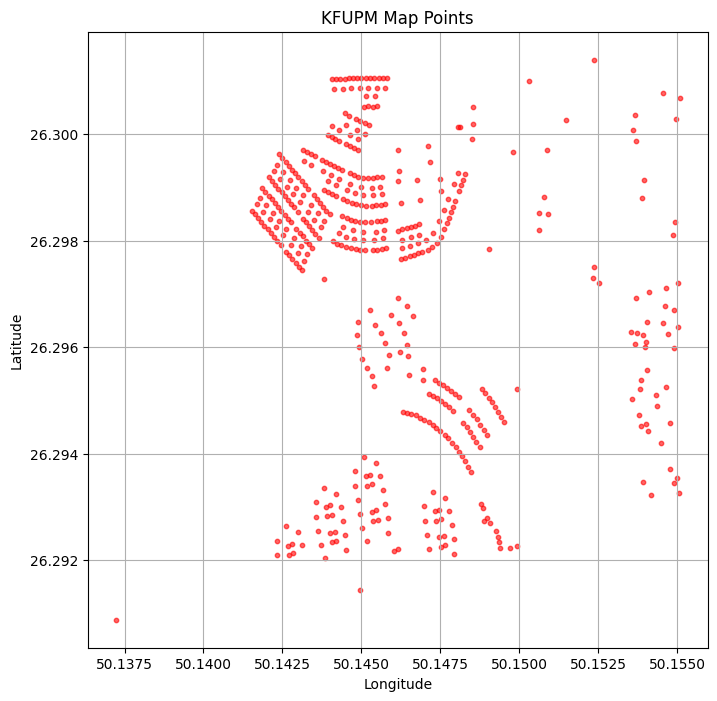

In [ ]:
# import json
# import folium
# import matplotlib.pyplot as plt

# Load the OSM JSON file
with open("KFUPMexport.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract coordinates
coords = []
for el in data["elements"]:
    if "center" in el:
        lat = el["center"]["lat"]
        lon = el["center"]["lon"]
        coords.append((lat, lon))

# --- 1) Interactive Map with Folium ---
# Center map on average coordinates
map_center = [sum(lat for lat, lon in coords)/len(coords),
              sum(lon for lat, lon in coords)/len(coords)]

m = folium.Map(location=map_center, zoom_start=16)

# Add points
for lat, lon in coords:
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(m)

# Save interactive map
m.save("kfupm_map.html")
print("Interactive map saved as kfupm_map.html")

# --- 2) Static Scatter Plot with Matplotlib ---
lats = [lat for lat, lon in coords]
lons = [lon for lat, lon in coords]

plt.figure(figsize=(8,8))
plt.scatter(lons, lats, s=10, c="red", alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KFUPM Map Points")
plt.grid(True)
plt.show()


In [ ]:
# import json
# import folium
# from IPython.display import display


# Load your data
with open("KFUPMexport.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract coordinates
coords = []
for el in data["elements"]:
    if "center" in el:
        lat = el["center"]["lat"]
        lon = el["center"]["lon"]
        coords.append((lat, lon))

# Calculate center of map
map_center = [sum(lat for lat, lon in coords)/len(coords),
              sum(lon for lat, lon in coords)/len(coords)]

# Create a folium map
m = folium.Map(location=map_center, zoom_start=16, tiles="OpenStreetMap")

# Add markers
for lat, lon in coords:
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Save interactive map
m.save("kfupm_map.html")
print("✅ Map saved as kfupm_map.html — open it in your browser.")



✅ Map saved as kfupm_map.html — open it in your browser.


In [ ]:
display(m)  # Shows interactive map inside notebook


In [ ]:
# import json
# import folium
# import numpy as np
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Load your OSM points ---
with open("KFUPMexport.json", "r", encoding="utf-8") as f:
    data = json.load(f)

points = [(el["center"]["lat"], el["center"]["lon"])
          for el in data["elements"] if "center" in el]

# --- Depot (repo) ---
lat_mean = np.mean([p[0] for p in points])
lon_mean = np.mean([p[1] for p in points])
depot = (lat_mean, lon_mean)

# --- Cluster into 7 transfer stations ---
X = np.array(points)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# --- Compute radius per cluster (max distance from center to its points) ---
radii = []
for i in range(7):
    cluster_points = [points[j] for j in range(len(points)) if labels[j] == i]
    center = centers[i]
    dists = [geodesic((lat, lon), (center[0], center[1])).meters for lat, lon in cluster_points]
    max_radius = max(dists) if dists else 100
    radii.append(max_radius + 50)  # add buffer

# --- Build map ---
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=16, tiles="OpenStreetMap")
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cadetblue"]

# Plot points by cluster
for (lat, lon), cluster_id in zip(points, labels):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color=colors[cluster_id],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Plot depot
folium.Marker(
    location=depot,
    icon=folium.Icon(color="black", icon="home", prefix="fa"),
    popup="Main Depot"
).add_to(m)

# Plot transfer stations
for idx, (lat, lon) in enumerate(centers):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color=colors[idx % len(colors)], icon="truck", prefix="fa"),
        popup=f"Truck {idx+1} Transfer Station"
    ).add_to(m)

    # Coverage circle (adaptive radius)
    folium.Circle(
        radius=radii[idx],
        location=[lat, lon],
        color=colors[idx % len(colors)],
        fill=True,
        fill_opacity=0.15
    ).add_to(m)

m.save("logistics_map_fixed.html")
m


In [ ]:
# import json
# import folium
# import numpy as np
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Load OSM points ---
with open("KFUPMexport.json", "r", encoding="utf-8") as f:
    data = json.load(f)

points = [(el["center"]["lat"], el["center"]["lon"])
          for el in data["elements"] if "center" in el]

# --- Main depot (repo) ---
lat_mean = np.mean([p[0] for p in points])
lon_mean = np.mean([p[1] for p in points])
depot = (lat_mean, lon_mean)

# --- Cluster into 7 trucks ---
X = np.array(points)
kmeans_truck = KMeans(n_clusters=7, random_state=42, n_init=10)
truck_labels = kmeans_truck.fit_predict(X)
truck_centers = kmeans_truck.cluster_centers_

# --- For each truck, create 5–6 transfer stations ---
station_centers = []
station_truck_map = []
for truck_id in range(7):
    cluster_points = X[truck_labels == truck_id]
    n_stations = 5 if truck_id % 2 == 0 else 6  # alternate 5 and 6
    n_stations = min(n_stations, len(cluster_points))  # avoid empty
    if n_stations > 1:
        km = KMeans(n_clusters=n_stations, random_state=42, n_init=10)
        km.fit(cluster_points)
        for c in km.cluster_centers_:
            station_centers.append((c[0], c[1]))
            station_truck_map.append(truck_id)
    else:
        station_centers.append(tuple(cluster_points.mean(axis=0)))
        station_truck_map.append(truck_id)

# --- Compute equal radius (max dist any point to nearest station) ---
def min_dist_to_station(pt, stations):
    return min(geodesic(pt, s).meters for s in stations)

radii = [min_dist_to_station(pt, station_centers) for pt in points]
equal_radius = max(radii) + 50  # add buffer

# --- Folium map ---
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=16, tiles="OpenStreetMap")
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cadetblue"]

# Original points (gray)
for lat, lon in points:
    folium.CircleMarker([lat, lon], radius=2, color="gray",
                        fill=True, fill_opacity=0.5).add_to(m)

# Depot
folium.Marker(
    depot,
    icon=folium.Icon(color="black", icon="home", prefix="fa"),
    popup="Main Depot"
).add_to(m)

# Trucks (squares) + their transfer stations (triangles + equal circle)
for idx, (lat, lon) in enumerate(truck_centers):
    folium.Marker(
        [lat, lon],
        icon=folium.Icon(color=colors[idx], icon="truck", prefix="fa"),
        popup=f"Truck {idx+1}"
    ).add_to(m)

for (lat, lon), t_id in zip(station_centers, station_truck_map):
    folium.Marker(
        [lat, lon],
        icon=folium.Icon(color=colors[t_id], icon="flag", prefix="fa"),
        popup=f"Transfer Station (Truck {t_id+1})"
    ).add_to(m)

    folium.Circle(
        radius=equal_radius,
        location=[lat, lon],
        color=colors[t_id],
        fill=True,
        fill_opacity=0.15
    ).add_to(m)

m.save("logistics_network.html")
m


In [ ]:
# import json
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans

# --- Load OSM points ---
with open("KFUPMexport.json", "r", encoding="utf-8") as f:
    data = json.load(f)

points = [(el["center"]["lat"], el["center"]["lon"])
          for el in data["elements"] if "center" in el]

# Depot (repo) = centroid
lat_mean = np.mean([p[0] for p in points])
lon_mean = np.mean([p[1] for p in points])
depot = (lat_mean, lon_mean)

# Trucks (7 clusters)
X = np.array(points)
kmeans_truck = KMeans(n_clusters=7, random_state=42, n_init=10)
truck_labels = kmeans_truck.fit_predict(X)
truck_centers = kmeans_truck.cluster_centers_

# Transfer stations (5–6 per truck)
station_centers = []
station_truck_map = []
for truck_id in range(7):
    cluster_points = X[truck_labels == truck_id]
    n_stations = 5 if truck_id % 2 == 0 else 6
    n_stations = min(n_stations, len(cluster_points))  # avoid empty
    if n_stations > 1:
        km = KMeans(n_clusters=n_stations, random_state=42, n_init=10)
        km.fit(cluster_points)
        for c in km.cluster_centers_:
            station_centers.append((c[0], c[1]))
            station_truck_map.append(truck_id)
    else:
        station_centers.append(tuple(cluster_points.mean(axis=0)))
        station_truck_map.append(truck_id)

# --- Build a structured DataFrame ---
records = []

# 1. Depot
records.append({"type": "Depot", "truck_id": None, "station_id": None,
                "lat": depot[0], "lon": depot[1]})

# 2. Trucks
for i, (lat, lon) in enumerate(truck_centers):
    records.append({"type": "Truck", "truck_id": i+1, "station_id": None,
                    "lat": lat, "lon": lon})

# 3. Transfer stations
for j, ((lat, lon), t_id) in enumerate(zip(station_centers, station_truck_map)):
    records.append({"type": "TransferStation", "truck_id": t_id+1, "station_id": j+1,
                    "lat": lat, "lon": lon})

# 4. Original points
for k, (lat, lon) in enumerate(points):
    records.append({"type": "Point", "truck_id": None, "station_id": None,
                    "lat": lat, "lon": lon})

df = pd.DataFrame(records)

# --- Show first few rows ---
print(df.head(20))

# --- Save all points to CSV (optional) ---
df.to_csv("map_points_export.csv", index=False)
print("✅ Exported all points to map_points_export.csv")


               type  truck_id  station_id        lat        lon
0             Depot       NaN         NaN  26.297066  50.146240
1             Truck       1.0         NaN  26.299588  50.144813
2             Truck       2.0         NaN  26.295399  50.154297
3             Truck       3.0         NaN  26.294010  50.148044
4             Truck       4.0         NaN  26.292784  50.144300
5             Truck       5.0         NaN  26.298565  50.142857
6             Truck       6.0         NaN  26.297929  50.146639
7             Truck       7.0         NaN  26.299296  50.152652
8   TransferStation       1.0         1.0  26.299021  50.145421
9   TransferStation       1.0         2.0  26.300896  50.145020
10  TransferStation       1.0         3.0  26.298319  50.144772
11  TransferStation       1.0         4.0  26.300037  50.144616
12  TransferStation       1.0         5.0  26.299174  50.144204
13  TransferStation       2.0         6.0  26.297032  50.154598
14  TransferStation       2.0         7.

# Create The Data

In [ ]:
# import math
# from typing import Optional
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt


def ceil_to_next_30min(hours: float) -> float:
    """
    Round up hours to the next 0.5 hour increment.
    Returns hours (float).
    """
    half_hours = math.ceil(hours * 2) / 2.0
    return half_hours


def hours_to_hhmm(hours: float) -> str:
    """
    Convert fractional hours to 'HH:MM' 24h string, clipping to 24:00 if needed.
    """
    total_minutes = int(round(hours * 60))
    if total_minutes >= 24 * 60:
        return "24:00"
    hh = total_minutes // 60
    mm = total_minutes % 60
    return f"{hh:02d}:{mm:02d}"


class HybridDeliverySimulator:
    """
    Simulator for hybrid truck+drone delivery on a square map (km coordinates).
    - Map coordinates are in [0, map_size_km] in both axes.
    - Warehouse (repo) is centered at (map_size_km/2, map_size_km/2).
    """

    def __init__(
        self,
        delivery_points: int = 100,
        drone_battery_capacity: float = 750.0,
        map_size_km: float = 20.0,
        n_trucks: int = 4,
        drones_per_truck: int = 2,
        drone_speed_kmph: float = 50.0,
        truck_speed_kmph: float = 80.0,
        drone_payload_limit_kg: float = 2.0,
        wind_speed_kmph: float = 5.0,
        wind_impact_factor: float = 0.02,
        transfer_min_per_truck: int = 4,
        transfer_max_per_truck: int = 6,
        time_window_buffer_min: int = 30,
        max_truck_stop_distance:float= 100.0,
        min_truck_stop_distance :float = 100.0,
        base_power_draw_w: float = 25.0,
        power_increase_per_kg_w: float = 25.0,

        seed: Optional[int] = None,
    ):
        self.delivery_points = delivery_points
        self.map_size_km = map_size_km
        self.n_trucks = n_trucks
        self.drones_per_truck = drones_per_truck
        self.n_drones = self.n_trucks * self.drones_per_truck

        # Speeds / physical parameters
        self.drone_speed_kmph = drone_speed_kmph
        self.truck_speed_kmph = truck_speed_kmph
        self.wind_speed_kmph = wind_speed_kmph

        # Distance
        self.min_truck_stop_distance= min_truck_stop_distance
        self.max_truck_stop_distance= max_truck_stop_distance

        # Battery / payload / Drone Config
        self.drone_battery_capacity = drone_battery_capacity  # Wh
        self.drone_payload_limit_kg = drone_payload_limit_kg
        self.wind_impact_factor = wind_impact_factor
        self.base_power_draw_w = base_power_draw_w
        self.power_increase_per_kg_w = power_increase_per_kg_w



        # Transfer station  / scheduling params
        self.transfer_min_per_truck = transfer_min_per_truck
        self.transfer_max_per_truck = transfer_max_per_truck
        self.time_window_buffer_min = time_window_buffer_min

        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        # Repo at center (consistent attribute name used by visualize_map)
        self.repo_point = (self.map_size_km / 2.0, self.map_size_km / 2.0)

        # Generate objects
        self.drone_max_range_km = self.cal_max_range()
        self.trucks = self._place_trucks()
        self.transfer_stations = self._generate_transfer_stations()
        self.delivery_points_df = self._generate_delivery_points()
        self.drones_df = self._generate_drones()

    # -------------------------
    # Positioning Functions
    # -------------------------
    def _place_trucks(self) -> pd.DataFrame:
        """
        Place trucks evenly across the map. Deterministic grid-like placement.
        Returns DataFrame with columns: truck_id, x_km, y_km
        """
        n = self.n_trucks
        base_min_distance = 0.2 * self.map_size_km
        lo, hi = 0.1 * self.map_size_km, 0.9 * self.map_size_km

        positions = []
        attempts = 0
        max_attempts = 50_000
        min_distance = base_min_distance

        while len(positions) < n and attempts < max_attempts:
            x = np.random.uniform(lo, hi)
            y = np.random.uniform(lo, hi)
            if all(np.hypot(x - px, y - py) >= min_distance for px, py in positions):
                positions.append((x, y))
            attempts += 1

            # Every few thousand failed tries, relax constraint slightly (e.g., -2%)
            if attempts % 5000 == 0 and len(positions) < n:
                min_distance *= 0.98  # or reduce by a fixed small epsilon

        if len(positions) < n:
            raise RuntimeError(
                f"Could not place {n} trucks with spacing ~{base_min_distance:.2f} km "
                f"after {attempts} attempts. Try increasing map_size_km or reducing spacing."
            )

        return pd.DataFrame({
            "truck_id": range(1, n + 1),
            "x_km": [p[0] for p in positions],
            "y_km": [p[1] for p in positions],})

    def _generate_transfer_stations(self) -> pd.DataFrame:
        """
        For each truck generate between transfer_min_per_truck and transfer_max_per_truck stations
        placed around the truck at different angles and random radii between min and max.
        Returns DataFrame with columns: station_id, truck_id, x_km, y_km, radius_km, angle_deg
        """
        rows = []
        station_id = 1

        for _, truck in self.trucks.iterrows():
            n_stations = np.random.randint(
                self.transfer_min_per_truck, self.transfer_max_per_truck + 1
            )

            # Spread stations around the truck — 360° coverage with some randomness
            base_angles = np.linspace(0, 360, n_stations, endpoint=False)
            jitter = np.random.uniform(-40, 40, size=n_stations)
            angles = (base_angles + jitter) % 360

            # Distance distribution: closer stops are more common (normal-like bias)
            radii = np.random.uniform(self.min_truck_stop_distance, self.max_truck_stop_distance, n_stations)
            radii += np.random.normal(0, (self.max_truck_stop_distance - self.min_truck_stop_distance) / 10, n_stations)
            radii = np.clip(radii, self.min_truck_stop_distance, self.max_truck_stop_distance)

            for ang, rad in zip(angles, radii):
                ang_rad = math.radians(ang)
                x = truck["x_km"] + rad * math.cos(ang_rad)
                y = truck["y_km"] + rad * math.sin(ang_rad)

                # Keep within map boundaries
                x = max(0.0, min(self.map_size_km, x))
                y = max(0.0, min(self.map_size_km, y))

                rows.append({
                    "station_id": station_id,
                    "truck_id": int(truck["truck_id"]),
                    "x_km": x,
                    "y_km": y,
                    "radius_km": rad,
                    "angle_deg": ang,
                })
                station_id += 1


        return pd.DataFrame(rows)

    # -------------------------
    # Delivery / Drone logic
    # -------------------------
    def _generate_delivery_points(self) -> pd.DataFrame:
        """
        Generate delivery points with:
          1) (x,y) sampled uniformly on the map.
          2) Assign to the nearest transfer station that is within the drone's one-way
            max range (self.cal_max_range()); if multiple are tied, choose randomly.
            If none are within range, fall back to the absolute nearest (rare).
          3) Random start time in [00:00..23:59], but for each *transfer station* no
            more than `self.drones_per_truck` DPs share the SAME start minute.
          4) End time computed from travel time:
              travel_time_hr =
                  (repo→station distance / truck_speed_kmph) +
                  (station→DP distance / drone_speed_kmph)
            window_len_hr = (2 * travel_time_hr) + (buffer_min/60) + extra_hr,
            where extra_hr ∈ {0, 2, 4, 6} (sampled uniformly).
          5) If start + window_len_hr > 24 hours, repeat steps (3) and (4) until it fits
            (with a safe cap on attempts; last resort clamps to end of day).
          6) Return the specified columns unchanged.
        """
        # --- setup ---
        n = self.delivery_points
        xs = np.random.uniform(0.0, self.map_size_km, n)
        ys = np.random.uniform(0.0, self.map_size_km, n)
        drone_one_way_max_km = float(self.cal_max_range())
        repo_x, repo_y = self.repo_point
        rows = []
        transfer_df = self.transfer_stations[["station_id", "x_km", "y_km"]]
        transfer_coords = transfer_df.to_numpy()  # output => [ [id,x,y], ... ]
        station_ids = transfer_coords[:, 0].astype(int)

        # Per-station start-time concurrency guard:
        # station_id -> { minute_index (0..1439) : count_at_that_minute }
        per_station_minute_counts: dict[int, dict[int, int]] = {}

        for i in range(n):
            x = float(xs[i])
            y = float(ys[i])
            w = float(np.round(np.random.uniform(0, self.drone_payload_limit_kg), 2))

            # --- 2) Assign nearest station within range; random tie-breaker ---
            min_inrange = float("inf")
            eps=1e-9
            inrange_idxs = []
            for idx in range(transfer_coords.shape[0]):
                sid = int(transfer_coords[idx, 0])
                sx  = float(transfer_coords[idx, 1])
                sy  = float(transfer_coords[idx, 2])
                d   = math.hypot(sx - x, sy - y)
                if d <= drone_one_way_max_km:
                    if d < min_inrange - eps:
                        min_inrange = d
                        inrange_idxs = [idx]
                    elif abs(d - min_inrange) <= eps:
                        inrange_idxs.append(idx)

            if inrange_idxs:
                # if there are multiple tied in-range, pick one randomly
                choice_idx = int(np.random.choice(inrange_idxs))
            else:
                # Pass 2: no in-range stations → pick the absolute nearest (still simple)
                min_abs = float("inf")
                best_idx = 0
                for idx in range(transfer_coords.shape[0]):
                    sx = float(transfer_coords[idx, 1])
                    sy = float(transfer_coords[idx, 2])
                    d  = math.hypot(sx - x, sy - y)
                    if d < min_abs - eps:
                        min_abs = d
                        best_idx = idx
                choice_idx = best_idx

            # Read back chosen station and distance
            assigned_station_id = int(transfer_coords[choice_idx, 0])
            station_x            = float(transfer_coords[choice_idx, 1])
            station_y            = float(transfer_coords[choice_idx, 2])
            dist_station_to_point_km = float(math.hypot(station_x - x, station_y - y))

            # --- Base for min_window_hrs column (keep as in your schema) ---
            truck_one_way_hr_for_min = dist_station_to_point_km /  float(self.truck_speed_kmph)
            buffer_hr = float(self.time_window_buffer_min) / 60.0
            min_window_hr = truck_one_way_hr_for_min + buffer_hr

            # --- Distances for travel time rule (requirement #4) ---
            # repo -> station (truck), station -> DP (drone)
            dist_repo_to_station_km = math.hypot(station_x - repo_x, station_y - repo_y)

            truck_speed = float(self.truck_speed_kmph)
            drone_speed = float(self.drone_speed_kmph)

            truck_time_hr = dist_repo_to_station_km / truck_speed
            drone_time_hr = (dist_station_to_point_km / drone_speed)*2
            travel_time_hr = truck_time_hr + drone_time_hr

            # Window length per requirement:
            extra_choices = np.array([8.0,12.0,20.0,20.0,23.0,20.0,16.0], dtype=float)  #[0.0, 2.0, 4.0, 6.0]

            if assigned_station_id not in per_station_minute_counts:
                per_station_minute_counts[assigned_station_id] = {}
            minute_counts = per_station_minute_counts[assigned_station_id]

            MAX_TRIES = 500
            success = False
            start_hr = 0.0
            end_hr = 0.0

            for _ in range(MAX_TRIES):
                # random start minute in [0, 1410]
                start_minute = int(np.random.randint(0, 23.5 * 60))
                # enforce: per station, at most `drones_per_truck` DPs share the SAME start minute
                if minute_counts.get(start_minute, 0) >= int(self.drones_per_truck):
                    continue  # pick a different minute

                start_hr_candidate = start_minute / 60.0
                extra_hr = float(np.random.choice(extra_choices))
                next_station= self.max_truck_stop_distance/ self.truck_speed_kmph
                window_len_hr = (next_station + travel_time_hr) + buffer_hr + extra_hr

                end_hr_candidate = start_hr_candidate + window_len_hr

                if end_hr_candidate <= 24.0:
                    # accept
                    minute_counts[start_minute] = minute_counts.get(start_minute, 0) + 1
                    start_hr = start_hr_candidate
                    end_hr = end_hr_candidate
                    success = True
                    break
                # else retry with a different start (and a resampled extra)

            if not success:
                window_len_hr = (next_station + travel_time_hr) + buffer_hr + float(np.random.choice(extra_choices))
                latest_start_hr = max(0.0, 24.0 - window_len_hr)
                # Try a few nearby minutes around latest_start_hr
                fitted = False
                for offset_min in range(0, 60):  # up to ~1h of wiggle room
                    cand_min = int(round(latest_start_hr * 60.0)) - offset_min
                    if cand_min < 0:
                        break
                    if minute_counts.get(cand_min, 0) < int(self.drones_per_truck):
                        minute_counts[cand_min] = minute_counts.get(cand_min, 0) + 1
                        start_hr = cand_min / 60.0
                        end_hr = min(24.0, start_hr + window_len_hr)
                        fitted = True
                        break
                if not fitted:
                    # Absolute fallback: assign the minute and clamp end
                    cand_min = int(round(latest_start_hr * 60.0))
                    minute_counts[cand_min] = minute_counts.get(cand_min, 0) + 1
                    start_hr = cand_min / 60.0
                    end_hr = min(24.0, start_hr + window_len_hr)

            # --- finalize row ---
            start_hhmm = hours_to_hhmm(start_hr)
            end_hhmm = hours_to_hhmm(end_hr)

            rows.append({
                "delivery_point_id": i + 1,
                "x_km": x, "y_km": y,
                "weight_kg": w,
                "assigned_station_id": assigned_station_id,
                "distance_from_station_km": round(dist_station_to_point_km, 4),
                "time_window_start": start_hhmm,
                "time_window_end": end_hhmm,
                "min_window_hrs": float(min_window_hr),
            })

        return pd.DataFrame(rows)


    def _generate_drones(self) -> pd.DataFrame:
        """
        Generate drones with references to trucks (2 per truck by default). Drones are not assigned to coordinates,
        but have speed/payload constraints and an assigned home truck.
        """
        rows = []
        drone_id = 1
        for _, truck in self.trucks.iterrows():
            for _ in range(self.drones_per_truck):
                rows.append(
                    {
                        "drone_id": drone_id,
                        "home_truck_id": int(truck["truck_id"]),
                        "drone_speed_kmph": self.drone_speed_kmph,
                        "drone_payload_limit_kg": self.drone_payload_limit_kg,
                    }
                )
                drone_id += 1
        return pd.DataFrame(rows)

    # -------------------------
    # Estimators
    # -------------------------
    def _estimate_drone_flight_time(self, one_way_distance_km: float) -> float:
        """
        Estimate round-trip drone flight time in minutes, accounting for wind impact.
        """
        effective_speed = self.drone_speed_kmph * (
            1 - (self.wind_impact_factor * (self.wind_speed_kmph / 50.0))
        )
        effective_speed = max(1e-6, effective_speed)
        time_hr = (one_way_distance_km * 2.0) / effective_speed
        return round(time_hr * 60.0, 2)

    def _estimate_truck_travel_time(self, one_way_distance_km: float) -> float:
        """
        Estimate truck travel time in minutes (one-way).
        """
        time_hr = one_way_distance_km / max(1e-6, self.truck_speed_kmph)
        return round(time_hr * 60.0, 2)

    # -------------------------
    # Public getters
    # -------------------------
    def get_delivery_points(self) -> pd.DataFrame:
        return self.delivery_points_df.copy()

    def get_trucks(self) -> pd.DataFrame:
        return self.trucks.copy()

    def get_transfer_stations(self) -> pd.DataFrame:
        return self.transfer_stations.copy()

    def get_drones(self) -> pd.DataFrame:
        return self.drones_df.copy()

    def get_map_size(self) -> float:
        return self.map_size_km
    def get_summary(self) -> dict:
        df = self.delivery_points_df
        return {
            "Total Deliveries": len(df),
            # "Drone Deliveries": int((df["delivery_mode"] == "drone").sum()),
            # "Truck Deliveries": int((df["delivery_mode"] == "truck").sum()),
            "Average Package Weight (kg)": float(round(df["weight_kg"].mean(), 2)),
            "Average Distance from Station (km)": float(round(df["distance_from_station_km"].mean(), 2)),
            "Number of Trucks": int(len(self.trucks)),
            "Number of Drones": int(len(self.drones_df)),
        }

    def get_array_data(self) -> dict:
        """
        Return all key objects (trucks, transfer stations, drones, deliveries) as NumPy arrays.
        Columns are kept in a fixed order for consistency.
        """
        arrays = {}

        # Trucks: [truck_id, x, y]
        trucks_df = self.trucks[["truck_id", "x_km", "y_km"]]
        arrays["trucks"] = trucks_df.to_numpy()

        # Transfer stations: [station_id, truck_id, x, y, radius_km, angle_deg]
        stations_df = self.transfer_stations[["station_id", "truck_id", "x_km", "y_km", "radius_km", "angle_deg"]]
        arrays["transfer_stations"] = stations_df.to_numpy()

        # Drones: [drone_id, home_truck_id, drone_speed_kmph, drone_payload_limit_kg]
        drones_df = self.drones_df[["drone_id", "home_truck_id", "drone_speed_kmph", "drone_payload_limit_kg"]]
        arrays["drones"] = drones_df.to_numpy()

        # Deliveries: [delivery_point_id, x, y, weight, assigned_station_id,
        #              distance_from_station_km, mode_encoded, time_start_hr, time_end_hr]
        deliveries_df = self.delivery_points_df.copy()
        arrays["repo"] = np.array([[self.repo_point[0], self.repo_point[1]]], dtype=np.float32)

        # # Encode delivery mode (drone=0, truck=1)
        # deliveries_df["mode_encoded"] = deliveries_df["delivery_mode"].map({"drone": 0, "truck": 1})

        # Convert time strings "HH:MM" → fractional hours (float)
        def hhmm_to_hours(hhmm: str) -> float:
            h, m = map(int, hhmm.split(":"))
            return h + m / 60.0

        deliveries_df["time_start_hr"] = deliveries_df["time_window_start"].apply(hhmm_to_hours)
        deliveries_df["time_end_hr"] = deliveries_df["time_window_end"].apply(hhmm_to_hours)

        deliveries_array = deliveries_df[["delivery_point_id", "x_km", "y_km", "weight_kg", "assigned_station_id", "time_start_hr", "time_end_hr"]].to_numpy()
        arrays["deliveries"] = deliveries_array

        return arrays

    # -------------------------
    # Max Drone Range
    # -------------------------
    def cal_max_range(self) -> float:
        """
        Calculates the estimated one-way maximum range (in km) a drone can travel
        before its battery dies, based on internal drone and environment parameters.

        Returns:
            float: Estimated one-way maximum range in kilometers.
        """

        # --- Constants / model assumptions ---
        base_power_draw_w = self.base_power_draw_w  # W at empty load
        power_increase_per_kg_w = self.power_increase_per_kg_w  # W/kg payload

        # --- Drone-specific parameters ---
        battery_wh = self.drone_battery_capacity  # Wh
        payload_kg = self.drone_payload_limit_kg
        airspeed_kmph = self.drone_speed_kmph
        wind_kmph = self.wind_speed_kmph
        wind_factor = self.wind_impact_factor  # fraction (e.g. 0.2)
        # Extra realism knobs (override on self if you want)
        usable_battery_fraction = float(getattr(self, "usable_battery_fraction", 0.8))   # keep 20% reserve
        drivetrain_efficiency   = float(getattr(self, "drivetrain_efficiency", 0.9))     # 0..1
        mission_overhead_minutes = float(getattr(self, "mission_overhead_minutes", 2.0)) # takeoff/landing/hover
        min_ground_speed_kmph   = float(getattr(self, "min_ground_speed_kmph", 5.0))     # avoid zero/neg speeds

        # --- Estimate power draw ---
        total_power_w = base_power_draw_w + (power_increase_per_kg_w * payload_kg)


        if total_power_w <= 0:
            return 0.0  # invalid configuration

        # --- Compute flight time ---
        # print (battery_wh)
        flight_time_h = (battery_wh*0.8) / total_power_w  # in hours
        # print(f"tatal flight time is: {flight_time_h}")

        # --- Adjust speed for headwind ---
        effective_ground_speed_kmph = airspeed_kmph - (wind_kmph * wind_factor)
        # print(f"effective ground speed is: {effective_ground_speed_kmph}")

        if effective_ground_speed_kmph <= 0:
            return 0.0  # can't fly against wind

        # --- Compute total possible distance (round-trip) ---
        total_distance_km = effective_ground_speed_kmph * flight_time_h
        # print(f"total distance is: {total_distance_km}")

        # Assume round trip (go and return), so divide by 2
        max_one_way_range_km = total_distance_km / 2

        return max_one_way_range_km

    # -------------------------
    # Helper: reachability
    # -------------------------
    def is_reachable(self, point: tuple) -> bool:
        """
        Determine whether a point (x,y) is within the drone one-way range of any transfer station.
        Currently ignores payload — only checks distance.
        """
        x, y = point
        if self.transfer_stations is None or len(self.transfer_stations) == 0:
            return False
        dists = np.sqrt((self.transfer_stations["x_km"].to_numpy() - x) ** 2 + (self.transfer_stations["y_km"].to_numpy() - y) ** 2)
        return (dists <= self.drone_max_range_km).any()

    # -------------------------
    # Visualize the map
    # -------------------------
    def visualize_map(self, title="Hybrid Truck-Drone Delivery Map", figsize=(10, 10)):
        """
        Visualize the map with trucks, transfer stations, and delivery points.
        """
        fig, ax = plt.subplots(figsize=figsize)

        # Plot repository
        if hasattr(self, "repo_point") and self.repo_point is not None:
            ax.scatter(self.repo_point[0], self.repo_point[1], c="black", marker="*", s=200, label="Repository", zorder=5)

        # Define truck colors and marker shapes
        colors = [
                "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
                "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
                "gold", "teal", "navy", "maroon"
            ]

        # For keeping track of legend handles
        legend_elements = []

        for idx, row in self.trucks.iterrows():
            truck_id = int(row["truck_id"])
            color = colors[idx % len(colors)]

            # Plot truck
            truck_marker = ax.scatter(row["x_km"], row["y_km"], c=color, marker="^", s=150, edgecolors="k", label=f"Truck {truck_id}", zorder=4)
            legend_elements.append(truck_marker)

            # Filter transfer stations
            ts_df = self.transfer_stations[self.transfer_stations["truck_id"] == truck_id]
            ts_coords = ts_df[["x_km", "y_km"]].values

            # Plot transfer stations
            ts_marker = None
            for _, ts in ts_df.iterrows():
                ts_marker = ax.scatter(ts["x_km"], ts["y_km"], c=color, marker="o", s=100, edgecolors="k", zorder=3)
                # Coverage circle
                circle = Circle((ts["x_km"], ts["y_km"]), self.drone_max_range_km, color=color, alpha=0.05)
                ax.add_patch(circle)

            # Add only one legend entry for transfer stations per truck
            if ts_marker:
                ts_marker.set_label(f"Transfer Stations (Truck {truck_id})")
                legend_elements.append(ts_marker)

            # Connect transfer stations
            for i in range(len(ts_coords)):
                for j in range(i + 1, len(ts_coords)):
                    ax.plot([ts_coords[i][0], ts_coords[j][0]],
                            [ts_coords[i][1], ts_coords[j][1]],
                            c=color, linestyle="--", linewidth=1.2, alpha=0.7, zorder=2)

        # Delivery points
        reachable_label_added = False
        for _, dp in self.delivery_points_df.iterrows():
            reachable = self.is_reachable((dp["x_km"], dp["y_km"]))
            color = "green" if reachable else "red"
            label = "Reachable DP" if reachable and not reachable_label_added else None
            if reachable:
                reachable_label_added = True
            ax.scatter(dp["x_km"], dp["y_km"], c=color, marker="x", s=80, label=label, zorder=1)

        # Legend (avoid duplicate labels)
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys(), loc="upper right", bbox_to_anchor=(1.35, 1))

        # Styling
        ax.set_xlim(0, self.map_size_km)
        ax.set_ylim(0, self.map_size_km)
        ax.set_title(title)
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.axis("equal")
        ax.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()



In [ ]:
# import math
# from typing import Tuple, Dict, List

def check_scenario_feasibility(sim) -> Tuple[bool, str]:
    """
    Fast precheck: does there exist at least ONE feasible schedule
    (single-DP sorties) that serves all DPs with time windows and battery limits?

    Only parameter: `sim` (HybridDeliverySimulator instance).

    Assumptions:
    - One DP per sortie (TS -> DP -> same TS), waiting allowed at TS before launch.
    - Drones are tied to their truck; each truck has sim.drones_per_truck identical drones.
    - No explicit service time at DP; add it if you later model it.
    - Horizon ends at 24.0 hours (same-day).
    - Uses a 10% battery reserve by default (conservative).
    """
    day_end_hr = 24.0

    # Effective ground speed (same logic as your estimator)
    eff_speed_kmph = float(sim.drone_speed_kmph) * (
        1 - (float(sim.wind_impact_factor) * (float(sim.wind_speed_kmph) / 50.0))
    )
    eff_speed_kmph = max(1e-6, eff_speed_kmph)

    # One-way max range from simulator
    max_one_way_km = float(getattr(sim, "drone_max_range_km", sim.cal_max_range()))

    # ----- check for the transfer stations existance  -----
    ts_df = sim.get_transfer_stations()
    if ts_df is None or len(ts_df) == 0:
        return False, "No transfer stations available."

    # station_id -> (truck_id, x, y)
    ts_info: Dict[int, tuple] = {
        int(r.station_id): (int(r.truck_id), float(r.x_km), float(r.y_km))
        for _, r in ts_df.iterrows()
    }
    # ----- check for trucks existance  -----
    trucks_df = sim.get_trucks()
    if trucks_df is None or len(trucks_df) == 0:
        return False, "No trucks available."

    drones_per_truck = int(sim.drones_per_truck)
    truck_drones_available: Dict[int, List[float]] = {
        int(r.truck_id): [0.0 for _ in range(drones_per_truck)]
        for _, r in trucks_df.iterrows()
    }
    # ----- check for time window existance  -----
    dp_df = sim.get_delivery_points().copy()
    if "time_window_start" not in dp_df or "time_window_end" not in dp_df:
        return False, "Delivery points lack time windows."

    # Convert "HH:MM" → fractional hours WITHOUT a helper function
    dp_df["tw_start"] = dp_df["time_window_start"].apply(
        lambda s: (int(s.split(":")[0]) + int(s.split(":")[1]) / 60.0) if isinstance(s, str) else float(s)
    )
    dp_df["tw_end"] = dp_df["time_window_end"].apply(
        lambda s: (int(s.split(":")[0]) + int(s.split(":")[1]) / 60.0) if isinstance(s, str) else float(s)
    )

    # Precompute candidate stations within one-way battery range
    candidates: Dict[int, List[tuple]] = {}  # dp_id -> list of (station_id, dist_km)
    for _, dp in dp_df.iterrows():
        dp_id = int(dp.delivery_point_id)
        x, y = float(dp.x_km), float(dp.y_km)

        feas_list = []
        for sid, (tid, sx, sy) in ts_info.items():
            d = math.hypot(x - sx, y - sy)
            if d <= max_one_way_km:  # one-way reachability
                feas_list.append((sid, d))
        feas_list.sort(key=lambda t: t[1])
        candidates[dp_id] = feas_list

    # Sort by earliest deadline
    dps_sorted = (
        dp_df.sort_values(by=["tw_end", "tw_start"])
            .reset_index(drop=True)
    )

    # ----- Greedy earliest-deadline assignment -----
    for _, dp in dps_sorted.iterrows():
        dp_id = int(dp.delivery_point_id)
        tw_start = float(dp.tw_start)
        tw_end   = float(dp.tw_end)

        feas_stations = candidates.get(dp_id, [])
        if not feas_stations:
            return False, f"DP {dp_id}: no station within one-way battery range."

        scheduled = False
        for sid, dist_km in feas_stations:
            truck_id, sx, sy = ts_info[sid]
            one_way_hr = dist_km / eff_speed_kmph
            if one_way_hr <= 0:
                continue

            drones_avail = truck_drones_available[truck_id]
            best_idx, best_finish = None, None

            for idx, avail_time in enumerate(drones_avail):
                latest_depart = tw_end - one_way_hr
                if latest_depart < 0:
                    continue

                # launch no earlier than availability and such that arrival >= tw_start
                depart  = max(avail_time, tw_start - one_way_hr, 0.0)
                arrival = depart + one_way_hr
                if arrival > tw_end + 1e-9:
                    continue

                # round-trip to SAME station
                return_time = arrival + one_way_hr
                if return_time > day_end_hr + 1e-9:
                    continue

                if (best_finish is None) or (return_time < best_finish):
                    best_finish, best_idx = return_time, idx

            if best_idx is not None:
                truck_drones_available[truck_id][best_idx] = best_finish
                scheduled = True
                break

        if not scheduled:
            return False, f"DP {dp_id}: cannot meet its time window with available drones."

    return True, "Feasible schedule exists (single-DP sorties, greedy EDD, using drone_max_range_km)."

In [ ]:
# import math
# from typing import Dict, List, Tuple, Optional

def plan_sequences(
    sim,
    start_time_hhmm: str = "08:00",
    dropoff_buffer_min: float = 2.0,     # minutes of handover/landing at the DP
    station_mode: str = "decide",        # "nearest" | "fixed" | "decide"
    window_policy: str = "arrival_within"  # "arrival_within" | "receive_within"
) -> Dict[str, object]:
    """
    Simulate per-truck station visits and parallel drone sorties, across all trucks concurrently.

    Returns a dict with THREE time-sorted arrays you asked for:
      - 'drone_array':  List[[drone_id, point_id, timeToLaunchHHMM, timeToReachThePointHHMM], ...]  (sorted by launch time)
      - 'points_array': List[[point_id, timeToVisitHHMM], ...]                                       (sorted by visit time = drone arrival)
      - 'stations_array': List[[transferStation_id, timeToVisitHHMM], ...]                           (sorted by station arrival; includes revisits)

    Extra keys (useful for debugging; feel free to ignore):
      - 'rejected_dp_ids': DPs that could not be scheduled inside their windows
      - 'trucks': per-truck [(station_id, station_arrival_hhmm), ...]
      - 'truck_dp_visits': per-truck [(dp_id, station_id, visit_time_hhmm)], time-sorted
      - 'drones': per-drone sequence of dp_ids (dict[drone_id] -> [dp_id, ...])
    """

    # ---------- helpers ----------
    def hhmm_to_minutes(hhmm: str) -> int:
        h, m = map(int, hhmm.split(":"))
        return h * 60 + m

    def minutes_to_hhmm(total_min: float) -> str:
        t = max(0, int(round(total_min)))
        h = min(24, t // 60)
        m = t % 60 if h < 24 else 0
        return f"{h:02d}:{m:02d}"

    def euclid(ax, ay, bx, by) -> float:
        return float(math.hypot(ax - bx, ay - by))

    # Prefer simulator estimators if available; otherwise compute from speeds
    def truck_minutes_for_km(km: float) -> float:
        if hasattr(sim, "_estimate_truck_travel_time"):
            return float(sim._estimate_truck_travel_time(km))
        v = getattr(sim, "truck_speed_kmph", 80.0)
        return (km / max(1e-9, float(v))) * 60.0

    def drone_roundtrip_minutes_for_km(one_way_km: float) -> float:
        if hasattr(sim, "_estimate_drone_flight_time"):
            return float(sim._estimate_drone_flight_time(one_way_km))
        v = getattr(sim, "drone_speed_kmph", 50.0)
        return (2.0 * one_way_km / max(1e-9, float(v))) * 60.0

    # One-way drone minutes from station→dp
    def drone_oneway_minutes_for_km(one_way_km: float) -> float:
        return drone_roundtrip_minutes_for_km(one_way_km) / 2.0

    # ---------- inputs ----------
    trucks_df   = sim.get_trucks()
    stations_df = sim.get_transfer_stations()
    dps_df      = sim.get_delivery_points()
    drones_df   = sim.get_drones()
    repo_x, repo_y = sim.repo_point

    # Lookups
    stations_by_truck: Dict[int, List[dict]] = {}
    for _, row in stations_df.iterrows():
        stations_by_truck.setdefault(int(row.truck_id), []).append(row.to_dict())

    dps_by_station: Dict[int, List[dict]] = {}
    for _, row in dps_df.iterrows():
        d = row.to_dict()
        d["win_start_min"] = float(hhmm_to_minutes(d["time_window_start"]))
        d["win_end_min"]   = float(hhmm_to_minutes(d["time_window_end"]))
        dps_by_station.setdefault(int(row["assigned_station_id"]), []).append(d)

    drones_by_truck: Dict[int, List[dict]] = {}
    for _, row in drones_df.iterrows():
        drones_by_truck.setdefault(int(row.home_truck_id), []).append(row.to_dict())

    # ---------- init ----------
    global_start_min = float(hhmm_to_minutes(start_time_hhmm))

    # final arrays you requested (we'll sort before returning)
    drone_array: List[List[object]] = []      # [drone_id, point_id, launch_hhmm, arrival_hhmm]
    points_array: List[List[object]] = []     # [point_id, arrival_hhmm]
    stations_array: List[List[object]] = []   # [station_id, station_arrival_hhmm] (for every visit)

    rejected_dp_ids: List[int] = []

    # Optional debug outputs
    trucks_timeline: Dict[int, List[Tuple[int, str]]] = {}
    drones_sequences: Dict[int, List[int]] = {int(r["drone_id"]): [] for _, r in drones_df.iterrows()}
    truck_dp_visits: Dict[int, List[Tuple[int, int, str]]] = {}

    # ---------- per truck simulation (independent; "concurrent") ----------
    for _, truck in trucks_df.iterrows():
        truck_id = int(truck.truck_id)
        truck_drones = drones_by_truck.get(truck_id, [])
        stations = stations_by_truck.get(truck_id, [])
        if not stations:
            trucks_timeline[truck_id] = []
            continue

        # Build a list of station_id -> pending DPs
        pending_by_station: Dict[int, List[dict]] = {}
        for st in stations:
            sid = int(st["station_id"])
            # copy list so we can pop from it
            pending = list(dps_by_station.get(sid, []))
            # sort once by earliest deadline then longest service (EDF->LPT tie-break)
            st_x, st_y = float(st["x_km"]), float(st["y_km"])
            def dp_key(r):
                dist = euclid(st_x, st_y, float(r["x_km"]), float(r["y_km"]))
                # LPT tie-break: negative service time (longer first) to reduce makespan
                srv = drone_roundtrip_minutes_for_km(dist) + float(dropoff_buffer_min)
                return (float(r["win_end_min"]), -srv, dist, int(r["delivery_point_id"]))
            pending_by_station[sid] = sorted(pending, key=dp_key)

        # If truck has no DPs, skip
        total_dps = sum(len(v) for v in pending_by_station.values())
        if total_dps == 0:
            trucks_timeline[truck_id] = []
            continue

        # ---- smart depot departure time (earliest needed) ----
        earliest_needed_dep = float("inf")
        for st in stations:
            sid = int(st["station_id"])
            st_x, st_y = float(st["x_km"]), float(st["y_km"])
            for dp in pending_by_station.get(sid, []):
                dp_x, dp_y = float(dp["x_km"]), float(dp["y_km"])
                win_start = float(dp["win_start_min"])
                truck_to_st_min = truck_minutes_for_km(euclid(repo_x, repo_y, st_x, st_y))
                drone_oneway_min = drone_oneway_minutes_for_km(euclid(st_x, st_y, dp_x, dp_y))
                need = win_start - (truck_to_st_min + drone_oneway_min + float(dropoff_buffer_min))
                if need < earliest_needed_dep:
                    earliest_needed_dep = need

        t_now = max(global_start_min, earliest_needed_dep if earliest_needed_dep != float("inf") else global_start_min)

        # ---- plan route order (sequence of station visits), allowing revisits until all DPs done ----
        trucks_timeline[truck_id] = []
        truck_dp_visits.setdefault(truck_id, [])

        # Current truck location (start at repo)
        loc_x, loc_y = float(repo_x), float(repo_y)

        # Drone readiness per drone (minutes)
        drone_ready: Dict[int, float] = {int(d["drone_id"]): float(t_now) for d in truck_drones}

        # helper: choose next station index based on mode
        def choose_next_station_id(current_time_min: float, cx: float, cy: float) -> Optional[int]:
            # Candidate stations with at least 1 pending DP
            candidates = [st for st in stations if len(pending_by_station.get(int(st["station_id"]), [])) > 0]
            if not candidates:
                return None

            if station_mode == "fixed":
                # lowest station_id first among those with pending DPs
                return int(sorted(candidates, key=lambda s: int(s["station_id"]))[0]["station_id"])

            if station_mode == "nearest":
                return int(min(
                    candidates,
                    key=lambda s: euclid(cx, cy, float(s["x_km"]), float(s["y_km"]))
                )["station_id"])

            # "decide": minimize predicted idle wait on arrival (EDF-aware)
            best_sid, best_score, best_dist = None, float("inf"), float("inf")
            for s in candidates:
                sid = int(s["station_id"])
                sx, sy = float(s["x_km"]), float(s["y_km"])
                travel = truck_minutes_for_km(euclid(cx, cy, sx, sy))
                eta = current_time_min + travel

                # earliest depart needed to hit earliest DP's start
                pending = pending_by_station.get(sid, [])
                if not pending:
                    continue
                # compute min of (tw_start - drone_oneway) among pending at station
                earliest_depart_need = float("inf")
                for dp in pending:
                    dp_x, dp_y = float(dp["x_km"]), float(dp["y_km"])
                    one_way = drone_oneway_minutes_for_km(euclid(sx, sy, dp_x, dp_y))
                    need = float(dp["win_start_min"]) - one_way
                    if need < earliest_depart_need:
                        earliest_depart_need = need

                predicted_idle = max(0.0, earliest_depart_need - eta)
                score = predicted_idle  # lower is better
                dist = travel
                if (score < best_score) or (score == best_score and dist < best_dist):
                    best_sid, best_score, best_dist = sid, score, dist

            return best_sid

        # We'll loop until all DPs are scheduled or we detect no progress in a full pass
        MAX_VISITS_GUARD = 50_000
        visits_done = 0

        while sum(len(v) for v in pending_by_station.values()) > 0 and visits_done < MAX_VISITS_GUARD:
            sid = choose_next_station_id(t_now, loc_x, loc_y)
            if sid is None:
                break  # nothing left

            # drive to station
            st = next(s for s in stations if int(s["station_id"]) == sid)
            sx, sy = float(st["x_km"]), float(st["y_km"])
            drive_min = truck_minutes_for_km(euclid(loc_x, loc_y, sx, sy))
            t_arrive = t_now + drive_min

            # record station arrival (for stations_array; we include revisits)
            stations_array.append([sid, minutes_to_hhmm(t_arrive)])
            trucks_timeline[truck_id].append((sid, minutes_to_hhmm(t_arrive)))

            # drones can't launch before truck arrives
            for did in drone_ready:
                drone_ready[did] = max(drone_ready[did], t_arrive)

            # schedule this station's pending DPs with m parallel drones
            station_pending = pending_by_station.get(sid, [])
            if not station_pending:
                # depart immediately
                t_now = t_arrive
                loc_x, loc_y = sx, sy
                visits_done += 1
                continue

            # local copies (we'll consume from the front)
            # Sorted already EDF->LPT in pending_by_station; we’ll iterate and assign greedily.
            served_indices = []
            station_finish = t_arrive
            made_any = False

            for idx, dp in enumerate(station_pending):
                dp_id = int(dp["delivery_point_id"])
                dp_x, dp_y = float(dp["x_km"]), float(dp["y_km"])
                win_start = float(dp["win_start_min"])
                win_end   = float(dp["win_end_min"])

                one_way_min = drone_oneway_minutes_for_km(euclid(sx, sy, dp_x, dp_y))
                # choose drone that yields earliest finish respecting window policy
                best = None  # (finish, drone_id, depart, arrival, recv)
                for did, ready in drone_ready.items():
                    # earliest we can depart and still arrive inside window
                    # depart must be >= ready and >= t_arrive
                    lb_depart = max(ready, t_arrive, win_start - one_way_min)
                    if window_policy == "arrival_within":
                        ub_depart = win_end - one_way_min
                    else:
                        ub_depart = win_end - one_way_min - float(dropoff_buffer_min)

                    if lb_depart > ub_depart:
                        continue

                    depart  = lb_depart
                    arrival = depart + one_way_min
                    recv    = arrival + float(dropoff_buffer_min)
                    finish  = recv + one_way_min

                    # final policy guard
                    if arrival < win_start:
                        continue
                    if window_policy == "arrival_within":
                        if arrival > win_end:
                            continue
                    else:
                        if recv > win_end:
                            continue

                    if (best is None) or (finish < best[0]):
                        best = (finish, int(did), depart, arrival, recv)

                if best is None:
                    # can't serve this DP at this visit; leave it for a revisit
                    continue

                # assign
                finish, did, depart, arrival, recv = best
                drone_ready[did] = finish
                station_finish = max(station_finish, finish)
                served_indices.append(idx)
                made_any = True

                drones_sequences[did].append(dp_id)
                # Arrays you asked:
                drone_array.append([did, dp_id, minutes_to_hhmm(depart), minutes_to_hhmm(arrival)])
                points_array.append([dp_id, minutes_to_hhmm(arrival)])
                truck_dp_visits[truck_id].append((dp_id, sid, minutes_to_hhmm(arrival)))

            # remove served DPs from this station list (reverse to keep indexes valid)
            for k in reversed(served_indices):
                station_pending.pop(k)

            # write back remaining
            pending_by_station[sid] = station_pending

            # truck departs when all assigned sorties for this visit complete
            t_now = max(t_now, station_finish)
            loc_x, loc_y = sx, sy

            # keep drone clocks ≥ truck time (moving station-to-station)
            for did in drone_ready:
                drone_ready[did] = max(drone_ready[did], t_now)

            # If we failed to serve anything here and there are still DPs, move on; revisit later
            visits_done += 1

        # Any DPs that never got scheduled for this truck are infeasible under given windows
        for pending in pending_by_station.values():
            for dp in pending:
                rejected_dp_ids.append(int(dp["delivery_point_id"]))

        # Sort per-truck DP visits by time
        if truck_dp_visits[truck_id]:
            truck_dp_visits[truck_id] = sorted(truck_dp_visits[truck_id], key=lambda x: x[2])

    # ---------- final sorting of the three arrays ----------
    # Drone array sorted by launch time
    drone_array.sort(key=lambda r: r[2])     # r[2] = timeToLaunchHHMM
    # Points array sorted by visit time (arrival)
    points_array.sort(key=lambda r: r[1])
    # Stations array sorted by station arrival time
    stations_array.sort(key=lambda r: r[1])

    # Also expose light summaries (optional)
    return {
        "drone_array": drone_array,               # [drone_id, point_id, launch_hhmm, arrival_hhmm]
        "points_array": points_array,             # [point_id, arrival_hhmm]
        "stations_array": stations_array,         # [station_id, station_arrival_hhmm] (per visit)
        "rejected_dp_ids": rejected_dp_ids,       # infeasible under current windows
        "trucks": {tid: lst for tid, lst in trucks_timeline.items()},
        "drones": drones_sequences,
        "truck_dp_visits": truck_dp_visits,
    }


In [ ]:
check = False
attempt = 0

while not check:
    attempt += 1
    print(f"Attempt #{attempt} ...")
    sim = HybridDeliverySimulator(
      delivery_points=50, #400
      map_size_km=30.0,  #400
      n_trucks=2,  #14
      drones_per_truck=2, #5
      drone_speed_kmph=80.0,
      truck_speed_kmph=100.0,
      drone_payload_limit_kg=20.0,
      drone_battery_capacity=2800.0,
      transfer_min_per_truck=4,   #12
      transfer_max_per_truck=5,#14
      min_truck_stop_distance=20.0,
      max_truck_stop_distance=30.0,
      time_window_buffer_min=10,
      wind_speed_kmph=5.0,
      wind_impact_factor=0.10,
      base_power_draw_w= 2000.0,#2000.0
      power_increase_per_kg_w=10.0,
      seed=None
  )
    ok, msg = check_scenario_feasibility(sim)
    print(f"  -> {msg}")
    check = ok
    if attempt >= 10:
        break

if ok:
    print(f"Feasible scenario found on attempt #{attempt}")
else:
  print(f"\n 🅾️🅾️🅾️ OPSI !!!! {attempt} attempts reached without finding a feasible plan.")
# `sim` now holds a feasible scenario


In [ ]:
print(f"the max range for the drone is {sim.cal_max_range()}")

the max range for the drone is 12.366666666666667


In [ ]:
check = False
attempt = 0
rejected_counts = []

while not check:
    attempt += 1
    covered=False
    print(f"Attempt #{attempt} ...")
    while not covered:
      sim = HybridDeliverySimulator(
      delivery_points=400, #400
      map_size_km=150.0,  #400
      n_trucks=18,  #14
      drones_per_truck=10, #5
      drone_speed_kmph=80.0,
      truck_speed_kmph=100.0,
      drone_payload_limit_kg=20.0,
      drone_battery_capacity=2800.0,
      transfer_min_per_truck=12,   #12
      transfer_max_per_truck=14,#14
      min_truck_stop_distance=20.0,
      max_truck_stop_distance=25.0,
      time_window_buffer_min=10,
      wind_speed_kmph=5.0,
      wind_impact_factor=0.10,
      base_power_draw_w= 2000.0,#2000.0
      power_increase_per_kg_w=10.0,
      seed=None
  )
      covered,msg = check_scenario_feasibility(sim)


    total_dps = sim.get_delivery_points().shape[0]
    all_dp_ids = set(sim.get_delivery_points()["delivery_point_id"].tolist())

    # run planner (function version)
    plan_raw = plan_sequences(
        sim,
        start_time_hhmm="00:00",
        dropoff_buffer_min=2.0,
        station_mode="decide",
        window_policy="arrival_within",
    )

    # map function outputs to your expected structures
    # plan_raw keys: 'drone_array', 'points_array', 'stations_array', 'rejected_dp_ids', ...
    served_ids = set([row[0] for row in plan_raw["points_array"]])
    rejected_ids = sorted(list(all_dp_ids - served_ids))

    plan = {
        "rejected_dp_ids": rejected_ids,                 # you were computing this diff; keep it
        "delivery_points": [(pid, t) for (pid, t) in plan_raw["points_array"]],
        "drones": plan_raw["drone_array"],
        "stations": plan_raw["stations_array"],
    }

    rejected = len(plan["rejected_dp_ids"])
    served = total_dps - rejected
    rejected_counts.append(rejected)

    print(f"  -> Rejected: {rejected} / {total_dps}  |  Served: {served}")

    check = (rejected == 0) or (len(rejected_counts) >= 10)

if rejected == 0:
    print(f"Feasible scenario found on attempt #{attempt}")
else:
    best = min(rejected_counts)
    print("10 attempts reached without finding a fully feasible plan.")
    print(f"Minimum rejected deliveries observed: {best}  |  Best served: {total_dps - best}")

print(
    f"\nFinal attempt — Rejected: {len(plan['rejected_dp_ids'])}, "
    f"Served: {len(plan['delivery_points'])} "
    f"Reject Ratio : {(len(plan['rejected_dp_ids'])/total_dps)*100:.2f}%"
)


Attempt #1 ...
  -> Rejected: 124 / 400  |  Served: 276
Attempt #2 ...


KeyboardInterrupt: 

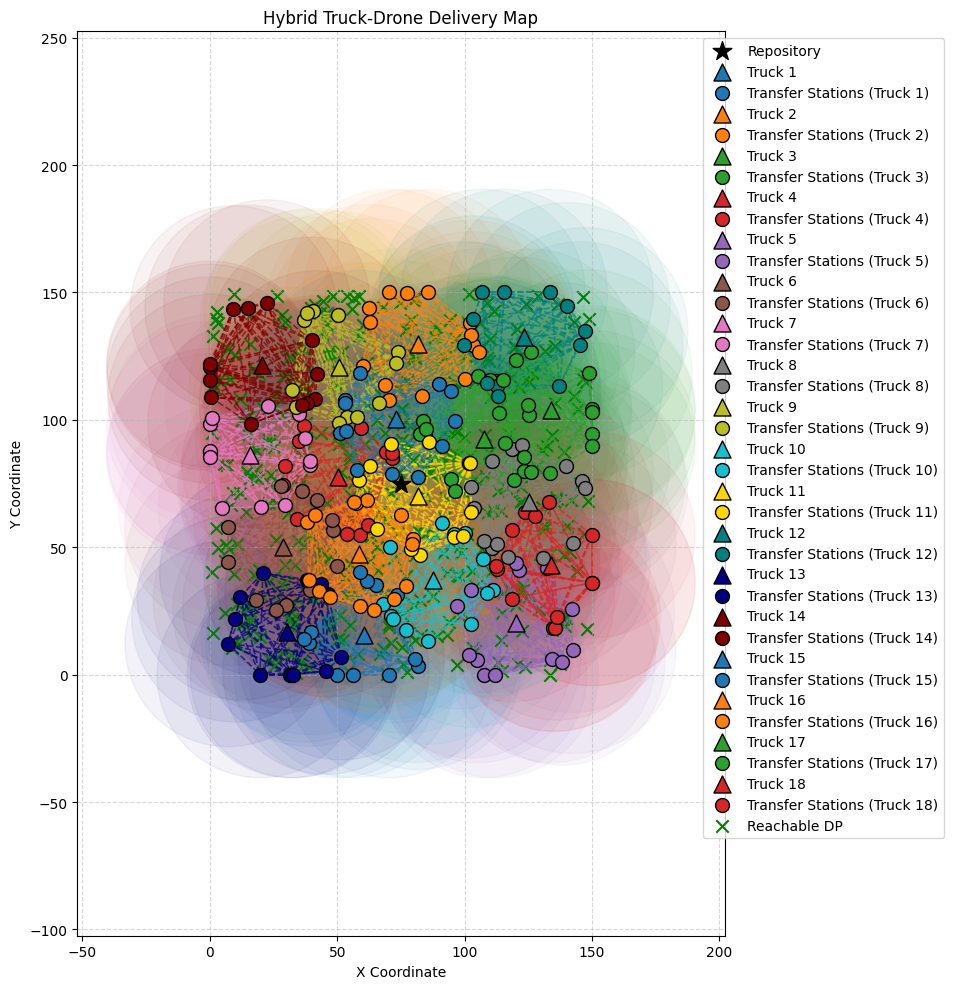

In [ ]:
sim.visualize_map()

In [ ]:


print("Trucks:")
print(sim.get_trucks())
print("\nTransfer Stations (first 10):")
print(sim.get_transfer_stations().head(10))
print("\nDelivery points (first 10):")
print(sim.get_delivery_points().head(10))
print("\nDrones:")
print(sim.get_drones())
print(f"The drone max range in one charge {sim.cal_max_range()} KM     🚇")


arrays = sim.get_array_data()

print("Trucks array:\n", arrays['trucks'])
print("Transfer stations array:\n", arrays['transfer_stations'][:5])  # first 5
print("Drones array:\n", arrays['drones'])
print("Deliveries array:\n", arrays['deliveries'][:5])  # first 5
print (f"The Repo array coordinates : x{arrays['repo'][0][0]} , y {arrays['repo'][0][1]}")


Trucks:
   truck_id       x_km       y_km
0         1  19.382495  23.246095
1         2  26.852337  11.524164
2         3   5.223998  13.962377
3         4  23.052958   3.628509

Transfer Stations (first 10):
   station_id  truck_id       x_km       y_km  radius_km   angle_deg
0           1         1  30.000000  30.000000  60.000000    9.498255
1           2         1  30.000000  30.000000  77.436508   59.963429
2           3         1   0.000000  22.930368  79.095269  180.228710
3           4         1   0.000000   0.000000  69.270842  204.767526
4           5         1   6.109974   0.000000  67.989323  258.742729
5           6         2  30.000000  30.000000  68.522209   21.850221
6           7         2  30.000000  30.000000  67.234573   55.069439
7           8         2  17.761064  30.000000  67.816605   97.704080
8           9         2   0.000000   0.000000  62.957841  205.233788
9          10         2   0.000000   0.000000  71.362084  211.655224

Delivery points (first 10):
   

In [ ]:
display(sim.get_delivery_points().sort_values(by='assigned_station_id').head(10))

,delivery_point_id,x_km,y_km,weight_kg,assigned_station_id,distance_from_station_km,time_window_start,time_window_end,min_window_hrs
45,46,27.502132,24.995006,6.89,2,5.5937,20:28,21:47,0.222604
0,1,0.700786,21.952192,12.94,3,1.2033,02:03,07:13,0.178700
13,14,7.631371,23.921826,6.85,3,7.6955,02:09,07:29,0.243622
5,6,3.491826,19.500842,17.57,3,4.8943,09:00,16:16,0.215610
27,28,7.989254,22.984068,1.40,3,7.9894,11:07,12:27,0.246561
34,35,0.899154,24.027397,19.63,3,1.4184,09:47,14:57,0.180851
33,34,1.429577,23.114479,15.11,3,1.4414,13:45,16:55,0.181081
23,24,5.987954,18.336720,9.72,3,7.5470,01:08,02:28,0.242137
16,17,9.305146,2.303145,12.94,5,3.9387,13:40,20:54,0.206054
17,18,9.189352,1.928596,2.55,5,3.6335,18:04,23:18,0.203001


In [ ]:
display(sim.get_trucks())

,truck_id,x_km,y_km
0,1,60.429820,15.700144
1,2,81.769600,129.918426
2,3,107.408985,92.509229
3,4,50.349135,77.588749
4,5,120.332401,20.109030
5,6,28.643008,49.953097
6,7,15.778713,86.241418
7,8,125.181916,67.698172
8,9,50.767506,120.732165
9,10,87.675664,37.096298


# DQN


## Build The DQN Model

## New DQN model


### DeliveryEnvironment

In [ ]:
# === Cell 1: DeliveryEnvironment (uses HybridDeliverySimulator instance per episode) ===
# from typing import Optional, Callable, Dict, Tuple, List
# import math
# import numpy as np

# Assumes HybridDeliverySimulator is already defined/imported in your notebook.

class DeliveryEnvironment:
    """
    RL environment for hybrid truck+drone delivery.

    Key points:
    - Dataset is an instance of HybridDeliverySimulator provided per episode via reset(sim=...).
    - Time windows are HARD: drone round-trip must finish <= window_end (minutes).
    - Each delivery must use its assigned nearest station (belongs to a specific truck).
    - Per-truck concurrency: 2 drones per truck; we track per-drone next-free times.
    - Action = choose NEXT delivery index (0..K-1). Invalid/served actions are penalized by the agent via masking.
    """
    def __init__(self, scheduler_config: Optional[Dict] = None, simulator_factory: Optional[Callable[[Dict], "HybridDeliverySimulator"]] = None):
        # Config is only used to size the state/action spaces or as a fallback if you call reset() without a sim
        self.cfg = scheduler_config or {}
        self.simulator_factory = simulator_factory

        # Default sizing (override at runtime after first reset)
        self.n_trucks = int(self.cfg.get("n_trucks", 4))
        self.drones_per_truck = int(self.cfg.get("drones_per_truck", 2))
        self.max_actions = int(self.cfg.get("delivery_points", 100))

        # State size: [ per-drone next-free times | served_ratio | remaining_ratio | makespan_norm ]
        self.state_size = (self.n_trucks * self.drones_per_truck) + 3

        # Episode vars
        self.sim = None
        self.repo_xy = None
        self.trucks_arr = None
        self.stations_arr = None
        self.deliveries_arr = None

        self.station_index = {}       # station_id -> (truck_id, x, y)
        self.truck_id_to_idx = {}     # truck_id -> 0..n_trucks-1

        self.drone_free_min = None    # shape [n_trucks, 2]
        self.served = None            # [K] bool
        self.max_oneway_km = 0.0
        self.K = 0
        self.steps = 0
        self.total_reward = 0.0
        self.total_energy = 0.0
        self.infeasible_tries = 0
        self.makespan_min = 0

    # ---------- Helpers ----------
    @staticmethod
    def _minutes(hours: float) -> int:
        m = int(round(float(hours) * 60.0))
        return max(0, min(24 * 60, m))

    @staticmethod
    def _euclid(ax: float, ay: float, bx: float, by: float) -> float:
        return float(math.hypot(ax - bx, ay - by))

    def _energy(self, distance_km: float, payload_kg: float) -> float:
        # Simple shaping proxy (Wh-ish). You can replace by your power model if needed.
        base = 0.05
        weight = 0.03 * payload_kg
        return (2.0 * distance_km) * (base + weight)

    def _update_makespan(self):
        self.makespan_min = int(self.drone_free_min.max()) if self.drone_free_min is not None else 0

    # ---------- Public API ----------
    def observation_space_shape(self) -> Tuple[int]:
        return (self.state_size,)

    def action_space_n(self) -> int:
        return int(self.max_actions)

    def reset(self, sim: Optional["HybridDeliverySimulator"] = None):
        """
        Reset the environment for a new episode.
        Pass a HybridDeliverySimulator instance via sim=... (RECOMMENDED).
        If None and simulator_factory is provided, we call it; otherwise we try to build from cfg.
        """
        if sim is not None:
            self.sim = sim
        elif self.simulator_factory is not None:
            self.sim = self.simulator_factory(self.cfg)
        else:
            # Fallback: create from cfg (not recommended if you want full control from outside)
            self.sim = HybridDeliverySimulator(**self.cfg)

        arrays = self.sim.get_array_data()
        self.repo_xy = arrays["repo"][0]                       # [x, y]
        self.trucks_arr = arrays["trucks"]                     # [truck_id, x, y]
        self.stations_arr = arrays["transfer_stations"]        # [station_id, truck_id, x, y, radius_km, angle_deg]
        self.deliveries_arr = arrays["deliveries"]             # [dp_id, x, y, weight, assigned_station_id, start_hr, end_hr]

        # Update sizing from the real simulator
        self.n_trucks = int(self.sim.n_trucks)
        self.drones_per_truck = int(self.sim.drones_per_truck)
        self.max_actions = int(self.sim.delivery_points) if hasattr(self.sim, "delivery_points") else int(self.deliveries_arr.shape[0])
        self.state_size = (self.n_trucks * self.drones_per_truck) + 3

        # Build lookups
        self.station_index = {}
        for row in self.stations_arr:
            sid = int(row[0]); tid = int(row[1]); x = float(row[2]); y = float(row[3])
            self.station_index[sid] = (tid, x, y)

        self.truck_id_to_idx = {int(trow[0]): i for i, trow in enumerate(self.trucks_arr)}

        # Initialize dynamics
        self.K = int(self.deliveries_arr.shape[0])
        self.drone_free_min = np.zeros((self.n_trucks, self.drones_per_truck), dtype=np.int32)
        self.served = np.zeros(self.K, dtype=bool)
        self.max_oneway_km = float(self.sim.drone_max_range_km)

        self.steps = 0
        self.total_reward = 0.0
        self.total_energy = 0.0
        self.infeasible_tries = 0
        self._update_makespan()

        return self._get_state()

    def _get_state(self) -> np.ndarray:
        tnorm = (self.drone_free_min.flatten().astype(np.float32)) / (24 * 60)  # normalize by a day
        served_ratio = float(self.served.sum()) / max(1, self.K)
        rem_ratio = float(self.K - self.served.sum()) / max(1, self.K)
        makespan_norm = float(self.makespan_min) / (24 * 60)

        s = np.concatenate([
            tnorm,
            np.array([served_ratio, rem_ratio, makespan_norm], dtype=np.float32)
        ], axis=0).astype(np.float32)

        # Defensive pad/cut to exact state_size
        if s.shape[0] < self.state_size:
            s = np.pad(s, (0, self.state_size - s.shape[0]), constant_values=0.0)
        elif s.shape[0] > self.state_size:
            s = s[:self.state_size]
        return s

    def get_valid_actions(self) -> List[int]:
        """
        Valid actions = unserved deliveries whose assigned station is within one-way max range.
        """
        valid = []
        for a in range(self.K):
            if self.served[a]:
                continue
            dp_id, x, y, w, assigned_sid, start_hr, end_hr = self.deliveries_arr[a]
            assigned_sid = int(assigned_sid)
            if assigned_sid not in self.station_index:
                continue
            tid, sx, sy = self.station_index[assigned_sid]
            dist = self._euclid(x, y, sx, sy)
            if dist <= self.max_oneway_km + 1e-9:
                valid.append(a)
        return valid

    def step(self, action: int):
        """
        Execute action = schedule delivery 'action' (0..K-1).
        - Choose earliest-free of the two drones of the owning truck.
        - If drone becomes available before window start, it waits (counts toward availability).
        - Must FINISH <= window end, else infeasible (penalize).
        """
        done = False
        info = {}
        reward = 0.0

        # Invalid indices or already served → penalize slightly
        if action < 0 or action >= self.K or self.served[action]:
            self.infeasible_tries += 1
            self.steps += 1
            # Small penalty; agent should avoid these via masking
            return self._get_state(), -10.0, self._maybe_done(), {"invalid": True}

        dp_id, x, y, w, assigned_sid, start_hr, end_hr = self.deliveries_arr[action]
        assigned_sid = int(assigned_sid)
        start_min = self._minutes(float(start_hr))
        end_min = self._minutes(float(end_hr))

        if assigned_sid not in self.station_index:
            self.infeasible_tries += 1
            self.steps += 1
            return self._get_state(), -20.0, self._maybe_done(), {"reason": "missing_station"}

        truck_id, sx, sy = self.station_index[assigned_sid]
        t_idx = self.truck_id_to_idx.get(int(truck_id), None)
        if t_idx is None or t_idx >= self.n_trucks:
            self.infeasible_tries += 1
            self.steps += 1
            return self._get_state(), -20.0, self._maybe_done(), {"reason": "bad_truck"}

        dist_km = self._euclid(x, y, sx, sy)
        if dist_km > self.max_oneway_km + 1e-9:
            self.infeasible_tries += 1
            self.steps += 1
            return self._get_state(), -50.0, self._maybe_done(), {"reason": "out_of_range", "distance_km": float(dist_km)}

        # Flight time (round-trip) using simulator's estimator
        flight_min = int(round(self.sim._estimate_drone_flight_time(one_way_distance_km=dist_km)))

        # Pick earliest-free of the 2 drones
        drone_slot = int(np.argmin(self.drone_free_min[t_idx]))
        drone_free_at = int(self.drone_free_min[t_idx, drone_slot])

        earliest_start = max(drone_free_at, start_min)
        wait_min = max(0, earliest_start - drone_free_at)
        finish_min = earliest_start + flight_min

        feasible = (finish_min <= end_min)
        if not feasible:
            self.infeasible_tries += 1
            self.steps += 1
            return self._get_state(), -50.0, self._maybe_done(), {
                "reason": "window_violation",
                "start_min": start_min, "end_min": end_min,
                "earliest_start": earliest_start, "finish_min": finish_min,
                "flight_min": flight_min
            }

        # Commit: mark served and update availability
        self.served[action] = True
        self.drone_free_min[t_idx, drone_slot] = finish_min
        self._update_makespan()

        # Reward shaping
        reward += 10.0  # success base
        slack = max(0, end_min - finish_min)             # earlier is better
        reward += 0.005 * slack
        reward -= 0.01 * wait_min                        # discourage idle
        energy = self._energy(dist_km, float(w))
        reward -= 0.5 * energy

        self.total_reward += reward
        self.total_energy += energy
        self.steps += 1

        # Episode end
        done = self._maybe_done()
        if done and self.served.all():
            reward += 25.0
            reward += 15.0 * (1.0 - (self.makespan_min / (24 * 60)))

        info = {
            "truck_id": int(truck_id),
            "drone_slot": int(drone_slot),
            "start_min": int(earliest_start),
            "finish_min": int(finish_min),
            "wait_min": int(wait_min),
            "flight_min": int(flight_min),
            "distance_km": float(dist_km),
            "energy": float(energy),
            "makespan_min": int(self.makespan_min),
            "served_count": int(self.served.sum()),
            "remaining": int(self.K - self.served.sum()),
        }
        return self._get_state(), float(reward), bool(done), info

    def _maybe_done(self) -> bool:
        # Terminate when all deliveries are served or safety bound on steps (K)
        return bool(self.served.all() or self.steps >= self.K)

    # Convenience summary
    def render_summary(self) -> Dict:
        return {
            "deliveries": int(self.K),
            "served": int(self.served.sum()),
            "makespan_min": int(self.makespan_min),
            "total_energy": float(self.total_energy),
            "total_reward": float(self.total_reward),
            "infeasible_tries": int(self.infeasible_tries),
            "n_trucks": int(self.n_trucks),
            "drones_per_truck": int(self.drones_per_truck),
            "max_one_way_range_km": float(self.max_oneway_km),
        }


### DQN Networks

In [ ]:
# === Cell 2: DQN Networks (Standard, Dueling, Simplified Rainbow) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """Standard MLP Deep Q-Network."""
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256, 128], dropout_p=0.0):
        super().__init__()
        layers, prev = [], state_size
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            if dropout_p and dropout_p > 0:
                layers += [nn.Dropout(dropout_p)]
            prev = h
        layers += [nn.Linear(prev, action_size)]
        self.net = nn.Sequential(*layers)
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


class DuelingDQN(nn.Module):
    """Dueling architecture (Value + Advantage)."""
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256], dropout_p=0.0):
        super().__init__()
        hs0, hs1 = hidden_sizes
        shared = [nn.Linear(state_size, hs0), nn.ReLU()]
        if dropout_p and dropout_p > 0: shared += [nn.Dropout(dropout_p)]
        shared += [nn.Linear(hs0, hs1), nn.ReLU()]
        if dropout_p and dropout_p > 0: shared += [nn.Dropout(dropout_p)]
        self.shared = nn.Sequential(*shared)

        self.value = nn.Sequential(nn.Linear(hs1, 128), nn.ReLU(), nn.Linear(128, 1))
        self.adv   = nn.Sequential(nn.Linear(hs1, 128), nn.ReLU(), nn.Linear(128, action_size))
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        s = self.shared(x)
        v = self.value(s)                    # [B, 1]
        a = self.adv(s)                      # [B, A]
        return v + (a - a.mean(dim=1, keepdim=True))


class RainbowDQN(nn.Module):
    """
    Simplified Rainbow head (distributional logits → probs → expected Q),
    still optimized with scalar TD target (not full categorical projection).
    """
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256], atoms=51, Vmin=-10, Vmax=10):
        super().__init__()
        self.atoms = int(atoms)
        self.support = torch.linspace(float(Vmin), float(Vmax), self.atoms)

        hs0, hs1 = hidden_sizes
        self.shared = nn.Sequential(
            nn.Linear(state_size, hs0), nn.ReLU(),
            nn.Linear(hs0, hs1), nn.ReLU()
        )
        self.head = nn.Linear(hs1, action_size * self.atoms)
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        z = self.shared(x)                                  # [B, hs1]
        z = self.head(z)                                    # [B, A*atoms]
        z = z.view(-1, self.head.out_features // self.atoms, self.atoms)  # [B, A, atoms]
        probs = torch.softmax(z, dim=2)
        q = torch.sum(probs * self.support.to(z.device), dim=2)           # [B, A]
        return q


def create_network(network_type="dueling",
                   state_size=None,
                   action_size=None,
                   hidden_sizes=[512, 256, 128],
                   dropout_p=0.0,
                   **kwargs):
    if network_type == "standard":
        return DQN(state_size, action_size, hidden_sizes=hidden_sizes, dropout_p=dropout_p)
    elif network_type == "dueling":
        return DuelingDQN(state_size, action_size, hidden_sizes=hidden_sizes[:2], dropout_p=dropout_p)
    elif network_type == "rainbow":
        return RainbowDQN(state_size, action_size, hidden_sizes=hidden_sizes[:2], **kwargs)
    else:
        raise ValueError(f"Unknown network_type: {network_type}")


### DQN Agent

In [ ]:
# === Cell 3: DQN Agent (action masking + masked Double-DQN targets) ===
import random
from collections import deque, namedtuple
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# create_network must be available from Cell 2

def build_mask(valid_actions, action_size, K_current=None):
    """
    Returns a float mask of shape [action_size]: 1.0 valid, 0.0 invalid.
    If valid_actions is None, mark [0..K_current-1] as valid.
    """
    mask = np.zeros(action_size, dtype=np.float32)
    if valid_actions is None:
        if K_current is None:
            mask[:] = 1.0
        else:
            mask[:int(K_current)] = 1.0
        return mask
    for a in valid_actions:
        if K_current is None or a < K_current:
            mask[int(a)] = 1.0
    return mask


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class DQNAgent:
    """
    DQN Agent supporting multiple backbones: 'standard', 'dueling', 'rainbow'.
    Uses action masking at selection time and in Double-DQN target computation.
    """
    def __init__(self,
                 state_size,
                 action_size,
                 lr=1e-3,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_decay=0.995,
                 epsilon_min=0.01,
                 memory_size=10000,
                 batch_size=64,
                 target_update=100,
                 network_type="dueling",
                 hidden_sizes=[512, 256, 128],
                 dropout_p=0.0,
                 use_soft_update=True,
                 tau=0.005,
                 **net_kwargs):
        self.state_size = int(state_size)
        self.action_size = int(action_size)
        self.lr = float(lr)
        self.gamma = float(gamma)
        self.epsilon = float(epsilon)
        self.epsilon_decay = float(epsilon_decay)
        self.epsilon_min = float(epsilon_min)
        self.batch_size = int(batch_size)
        self.target_update = int(target_update)
        self.use_soft_update = bool(use_soft_update)
        self.tau = float(tau)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[DQNAgent] device = {self.device}")

        # Networks
        self.q_network = create_network(network_type, state_size, action_size,
                                        hidden_sizes=hidden_sizes, dropout_p=dropout_p, **net_kwargs).to(self.device)
        self.target_network = create_network(network_type, state_size, action_size,
                                             hidden_sizes=hidden_sizes, dropout_p=dropout_p, **net_kwargs).to(self.device)
        self.update_target_network(hard=True)

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)

        self.memory = deque(maxlen=memory_size)
        self.Experience = namedtuple("Experience",
                                     ["state", "action", "reward", "next_state", "done", "next_valid_mask"])

        self.step_count = 0
        self.episode_count = 0
        self.training_losses = []

        print(f"[DQNAgent] parameters = {count_parameters(self.q_network)}")

    # --- Target update ---
    def update_target_network(self, hard=False):
        if hard:
            self.target_network.load_state_dict(self.q_network.state_dict())
        else:
            with torch.no_grad():
                for t, s in zip(self.target_network.parameters(), self.q_network.parameters()):
                    t.data.mul_(1.0 - self.tau).add_(self.tau * s.data)

    # --- Memory ---
    def remember(self, state, action, reward, next_state, done, next_valid_mask):
        exp = self.Experience(state, int(action), float(reward), next_state, bool(done), np.asarray(next_valid_mask, dtype=np.float32))
        self.memory.append(exp)

    # --- Policy ---
    def act(self, state, valid_actions=None, K_current=None, training=True):
        if training and random.random() <= self.epsilon:
            if valid_actions:
                if K_current is not None:
                    valid_actions = [a for a in valid_actions if a < K_current]
                if valid_actions:
                    return int(random.choice(valid_actions))
            return int(random.randrange(self.action_size))

        s = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)   # [1, S]
        self.q_network.eval()
        with torch.no_grad():
            q = self.q_network(s)  # [1, A]
        self.q_network.train()

        if valid_actions is not None:
            if K_current is not None:
                valid_actions = [a for a in valid_actions if a < K_current]
            mask = torch.full_like(q, float('-inf'))  # [1, A]
            if valid_actions:
                mask[0, valid_actions] = 0.0
            q = q + mask

        return int(q.argmax(dim=1).item())

    # --- Learn ---
    def replay(self):
        if len(self.memory) < self.batch_size:
            return None

        batch = random.sample(self.memory, self.batch_size)

        states = torch.tensor([e.state for e in batch], dtype=torch.float32, device=self.device)               # [B, S]
        actions = torch.tensor([e.action for e in batch], dtype=torch.long, device=self.device)                # [B]
        rewards = torch.tensor([e.reward for e in batch], dtype=torch.float32, device=self.device)             # [B]
        next_states = torch.tensor([e.next_state for e in batch], dtype=torch.float32, device=self.device)     # [B, S]
        dones = torch.tensor([e.done for e in batch], dtype=torch.bool, device=self.device)                    # [B]
        next_masks = torch.tensor([e.next_valid_mask for e in batch], dtype=torch.float32, device=self.device) # [B, A]; 1 valid

        # Q(s,a)
        q_sa = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)   # [B]

        # Masked Double-DQN
        with torch.no_grad():
            q_next_online = self.q_network(next_states)                     # [B, A]
            q_next_online[next_masks < 0.5] = float('-inf')                 # mask invalid next actions
            next_acts = q_next_online.argmax(dim=1)                         # [B]

            q_next_target = self.target_network(next_states).gather(1, next_acts.unsqueeze(1)).squeeze(1)  # [B]
            target = rewards + (~dones).float() * self.gamma * q_next_target

        loss = F.smooth_l1_loss(q_sa, target)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        self.scheduler.step()

        # epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

        # target update
        self.step_count += 1
        if self.use_soft_update:
            self.update_target_network(hard=False)
        elif (self.step_count % self.target_update) == 0:
            self.update_target_network(hard=True)

        loss_value = float(loss.item())
        self.training_losses.append(loss_value)
        return loss_value

    # --- Persistence / Stats ---
    def save_checkpoint(self, path):
        torch.save({
            "q_state": self.q_network.state_dict(),
            "t_state": self.target_network.state_dict(),
            "opt": self.optimizer.state_dict(),
            "sch": self.scheduler.state_dict(),
            "epsilon": self.epsilon,
            "step_count": self.step_count,
            "episode_count": self.episode_count,
            "losses": self.training_losses,
            "memory": list(self.memory)
        }, path)
        print(f"[DQNAgent] saved => {path}")

    def load_checkpoint(self, path):
        ckpt = torch.load(path, map_location=self.device)
        self.q_network.load_state_dict(ckpt["q_state"])
        self.target_network.load_state_dict(ckpt["t_state"])
        self.optimizer.load_state_dict(ckpt["opt"])
        self.scheduler.load_state_dict(ckpt["sch"])
        self.epsilon = ckpt["epsilon"]
        self.step_count = ckpt["step_count"]
        self.episode_count = ckpt["episode_count"]
        self.training_losses = ckpt["losses"]
        self.memory = deque(ckpt["memory"], maxlen=self.memory.maxlen)
        print(f"[DQNAgent] loaded <= {path}")

    def get_training_stats(self):
        recent = np.mean(self.training_losses[-100:]) if self.training_losses else 0.0
        return {
            "epsilon": float(self.epsilon),
            "step_count": int(self.step_count),
            "episode_count": int(self.episode_count),
            "memory_size": len(self.memory),
            "recent_loss": float(recent),
            "current_lr": float(self.scheduler.get_last_lr()[0]) if hasattr(self.scheduler, "get_last_lr") else self.lr
        }


## test

In [ ]:
# === Cell 4: Unified training/testing harness for Standard, Dueling, Rainbow DQN ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes Cells 1–3 are already executed:
# - DeliveryEnvironment (Cell 1)
# - DQN / DuelingDQN / RainbowDQN + create_network (Cell 2)
# - DQNAgent + build_mask (Cell 3)
# And HybridDeliverySimulator is defined/imported.

# ---------------------------
# Simulator config (base)
# ---------------------------
sim_base_cfg = {
    "delivery_points": 40,
    "n_trucks": 5,
    "drones_per_truck": 2,
    "map_size_km": 20.0,
    "seed": None,
    "drone_battery_capacity": 750.0,
    "drone_speed_kmph": 50.0,
    "truck_speed_kmph": 80.0,
    "drone_payload_limit_kg": 2.0,
    "wind_speed_kmph": 5.0,
    "wind_impact_factor": 0.02,
    "transfer_min_per_truck": 4,
    "transfer_max_per_truck": 6,
    "time_window_buffer_min": 30,
    "max_truck_stop_distance": 100.0,
    "min_truck_stop_distance": 100.0,
    "base_power_draw_w": 25.0,
    "power_increase_per_kg_w": 25.0,
}

def simulator_factory(env_cfg: dict, episode_seed: int = None) -> HybridDeliverySimulator:
    """Create a fresh simulator instance per episode (seeded)."""
    cfg = sim_base_cfg.copy()
    # Optionally map/override from env_cfg if you want tight coupling
    for k in ["delivery_points", "n_trucks", "drones_per_truck", "map_size_km"]:
        if k in env_cfg: cfg[k] = env_cfg[k]
    cfg["seed"] = episode_seed
    return HybridDeliverySimulator(**cfg)

# ---------------------------
# Experiment knobs
# ---------------------------
num_train_episodes = 60
num_test_episodes = 20
max_steps = 250
base_seed = 42  # used to vary episodes deterministically

# Single env used just to size the networks (state/action dims)
env_cfg_for_sizing = {
    "delivery_points": sim_base_cfg["delivery_points"],
    "n_trucks": sim_base_cfg["n_trucks"],
    "drones_per_truck": sim_base_cfg["drones_per_truck"],
    "map_size_km": sim_base_cfg["map_size_km"],
}
_sizing_env = DeliveryEnvironment(scheduler_config=env_cfg_for_sizing)
state_size = _sizing_env.observation_space_shape()[0]
action_size = _sizing_env.action_space_n()
del _sizing_env  # not needed anymore

# ---------------------------
# Per-model training/testing routine
# ---------------------------
def run_model(network_type: str,
              hidden_sizes=[512, 256, 128],
              dropout_p=0.0,
              lr=1e-3,
              gamma=0.99,
              epsilon=1.0,
              epsilon_decay=0.995,
              epsilon_min=0.01,
              memory_size=10000,
              batch_size=64,
              target_update=100,
              use_soft_update=True,
              tau=0.005,
              atoms=51, Vmin=-10, Vmax=10):
    """
    Train and test one DQN variant. Returns dict of rewards and a summary.
    """
    # Fresh env for this model (used at runtime; sim injected per episode)
    env = DeliveryEnvironment(scheduler_config=env_cfg_for_sizing)

    # Build agent
    net_kwargs = {}
    if network_type == "rainbow":
        net_kwargs.update({"atoms": atoms, "Vmin": Vmin, "Vmax": Vmax})

    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        lr=lr,
        gamma=gamma,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        epsilon_min=epsilon_min,
        memory_size=memory_size,
        batch_size=batch_size,
        target_update=target_update,
        network_type=network_type,          # "standard" | "dueling" | "rainbow"
        hidden_sizes=hidden_sizes,
        dropout_p=dropout_p,
        use_soft_update=use_soft_update,
        tau=tau,
        **net_kwargs
    )

    # -------- TRAIN --------
    train_rewards = []
    for ep in range(1, num_train_episodes + 1):
        sim = simulator_factory(env_cfg_for_sizing, episode_seed=base_seed + ep)
        state = env.reset(sim=sim)

        total_reward, done, step = 0.0, False, 0
        while not done and step < max_steps:
            valid_actions = env.get_valid_actions()
            action = agent.act(
                state,
                valid_actions=valid_actions,
                K_current=env.K,
                training=True
            )
            next_state, reward, done, info = env.step(action)
            next_valid_actions = env.get_valid_actions() if not done else []
            next_mask = build_mask(next_valid_actions, agent.action_size, K_current=env.K)

            agent.remember(state, action, reward, next_state, done, next_mask)

            state = next_state
            total_reward += reward
            step += 1

            agent.replay()                     # one SGD step
            agent.update_target_network(False) # soft update (since use_soft_update=True)

        agent.episode_count += 1
        train_rewards.append(total_reward)
        print(f"[{network_type.upper():7}] TRAIN Ep {ep:03d} | Steps {step:3d} | "
              f"Reward {total_reward:8.2f} | Eps {agent.epsilon:.3f} | "
              f"Makespan {getattr(env, 'makespan_min', 0)}")

    # -------- TEST (greedy) --------
    test_env = DeliveryEnvironment(scheduler_config=env_cfg_for_sizing)
    test_rewards = []
    for ep in range(1, num_test_episodes + 1):
        sim = simulator_factory(env_cfg_for_sizing, episode_seed=10_000 + ep)  # disjoint seeds
        state = test_env.reset(sim=sim)

        total_reward, done, step = 0.0, False, 0
        while not done and step < max_steps:
            valid_actions = test_env.get_valid_actions()
            action = agent.act(
                state,
                valid_actions=valid_actions,
                K_current=test_env.K,
                training=False      # greedy
            )
            next_state, reward, done, info = test_env.step(action)
            state = next_state
            total_reward += reward
            step += 1

        test_rewards.append(total_reward)
        print(f"[{network_type.upper():7}] TEST  Ep {ep:03d} | Steps {step:3d} | "
              f"Reward {total_reward:8.2f} | Makespan {getattr(test_env, 'makespan_min', 0)}")

    # Build summary
    summary = {
        "Model": network_type,
        "Train Avg": float(np.mean(train_rewards)),
        "Train Std": float(np.std(train_rewards)),
        "Train Max": float(np.max(train_rewards)),
        "Train Min": float(np.min(train_rewards)),
        "Test Avg": float(np.mean(test_rewards)),
        "Test Std": float(np.std(test_rewards)),
        "Test Max": float(np.max(test_rewards)),
        "Test Min": float(np.min(test_rewards)),
    }
    return {
        "agent": agent,
        "train_rewards": train_rewards,
        "test_rewards": test_rewards,
        "summary": summary
    }

# ---------------------------
# Run all three models
# ---------------------------
results = {}
for model_type in ["standard", "dueling", "rainbow"]:
    print("\n" + "="*18, f" {model_type.upper()} ", "="*18)
    results[model_type] = run_model(network_type=model_type)

# ---------------------------
# Plot rewards for each model
# ---------------------------
plt.figure(figsize=(10, 4))
for m in results:
    plt.plot(results[m]["train_rewards"], label=f"{m.capitalize()} Train")
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("Training Rewards by Model")
plt.legend(); plt.show()

plt.figure(figsize=(10, 4))
for m in results:
    plt.plot(results[m]["test_rewards"], marker='o', label=f"{m.capitalize()} Test")
plt.xlabel("Test Episode"); plt.ylabel("Total Reward"); plt.title("Test Rewards by Model")
plt.legend(); plt.show()

# ---------------------------
# Tabular summary
# ---------------------------
df_summary = pd.DataFrame([results[m]["summary"] for m in results])
display(df_summary.sort_values("Test Avg", ascending=False).reset_index(drop=True))



==================  STANDARD  ==================
[DQNAgent] device = cpu
[DQNAgent] parameters = 176552
[STANDARD] TRAIN Ep 001 | Steps  40 | Reward   509.41 | Eps 1.000 | Makespan 751


/tmp/ipython-input-2765987904.py:139: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.tensor([e.state for e in batch], dtype=torch.float32, device=self.device)               # [B, S]


[STANDARD] TRAIN Ep 002 | Steps  40 | Reward   498.15 | Eps 0.918 | Makespan 847
[STANDARD] TRAIN Ep 003 | Steps  40 | Reward   508.44 | Eps 0.751 | Makespan 640
[STANDARD] TRAIN Ep 004 | Steps  40 | Reward   281.47 | Eps 0.615 | Makespan 814
[STANDARD] TRAIN Ep 005 | Steps  40 | Reward   511.63 | Eps 0.503 | Makespan 804
[STANDARD] TRAIN Ep 006 | Steps  40 | Reward   511.93 | Eps 0.412 | Makespan 741
[STANDARD] TRAIN Ep 007 | Steps  40 | Reward   528.43 | Eps 0.337 | Makespan 800
[STANDARD] TRAIN Ep 008 | Steps  40 | Reward   487.55 | Eps 0.276 | Makespan 788
[STANDARD] TRAIN Ep 009 | Steps  40 | Reward    93.94 | Eps 0.226 | Makespan 776
[STANDARD] TRAIN Ep 010 | Steps  40 | Reward   489.43 | Eps 0.185 | Makespan 832
[STANDARD] TRAIN Ep 011 | Steps  40 | Reward   509.55 | Eps 0.151 | Makespan 754
[STANDARD] TRAIN Ep 012 | Steps  40 | Reward   504.01 | Eps 0.124 | Makespan 807
[STANDARD] TRAIN Ep 013 | Steps  40 | Reward   535.01 | Eps 0.101 | Makespan 593
[STANDARD] TRAIN Ep 014 | St

##  Delivery Environment

In [ ]:
# Block 1: Delivery Environment
# This block defines the reinforcement learning environment wrapper
class DeliveryEnvironment:
    """
    Reinforcement Learning Environment for Hybrid Truck-Drone Delivery
    """
    def __init__(self, scheduler_config: Dict = None):
        # Default configuration for the scheduler
        default_config = {
            'num_trucks': 3,
            'num_dps': 15,
            'map_size': (100, 100),
            'drone_speed': 20,
            'drone_battery': 500,
            'ts_per_truck': (3, 5),
            # 'ts_max_dist': 80,
            'seed': None,
            'max_retries': 50
        }

        if scheduler_config:
            default_config.update(scheduler_config)

        self.config = default_config

        # Initialize important attributes BEFORE calling reset()
        # Action space: for each delivery point, choose delivery method
        # 0: Direct drone from repo
        # 1-N: Via transfer station (where N is total number of transfer stations)
        self.max_transfer_stations = self.config['num_trucks'] * self.config['ts_per_truck'][1]
        self.action_space_size = 1 + self.max_transfer_stations  # Direct + all possible TSs

        # State space dimensions
        self.state_size = self._calculate_state_size()

        # Tracking variables
        self.current_dp_idx = 0
        self.delivery_assignments = []
        self.total_cost = 0.0
        self.done = False
        self.scheduler = None
        self.delivery_rewards = []

        # Now safe to call reset()
        self.reset()

    def _calculate_state_size(self):
        """Calculate the size of the state vector"""
        # State includes:
        # - Current DP position (2)
        # - Repository position (2)
        # - All truck positions (num_trucks * 2)
        # - All TS positions (max_ts * 2)
        # - Current DP index (1)
        # - Remaining DPs count (1)
        # - Distance features (repo_to_dp + all_ts_to_dp distances)

        truck_features = self.config['num_trucks'] * 2
        ts_features = self.max_transfer_stations * 2
        distance_features = 1 + self.max_transfer_stations  # repo_to_dp + ts_to_dp distances
        other_features = 2 + 2 + 1 + 1  # current_dp + repo + dp_idx + remaining_count

        return truck_features + ts_features + distance_features + other_features

    def reset(self):
        """Reset the environment for a new episode"""
        try:
            # Import your HybridDeliveryScheduler here
            # from your_module import HybridDeliveryScheduler
            self.scheduler = HybridDeliveryScheduler(**self.config)
        except RuntimeError:
            # If failed to generate feasible scenario, use a simpler one
            simpler_config = self.config.copy()
            simpler_config['num_dps'] = max(5, self.config['num_dps'] // 2)
            self.scheduler = HybridDeliveryScheduler(**simpler_config)

        self.current_dp_idx = 0
        self.delivery_assignments = []
        self.total_cost = 0.0
        self.done = False

        return self._get_state()


    def _get_state(self):
        """Get current state representation"""
        if self.done or self.current_dp_idx >= len(self.scheduler.delivery_points):
            # Return zero state if done
            return np.zeros(self.state_size)

        current_dp = self.scheduler.delivery_points[self.current_dp_idx]
        state = []

        # Current DP position
        state.extend([current_dp[0].item(), current_dp[1].item()])

        # Repository position
        state.extend([self.scheduler.repo[0].item(), self.scheduler.repo[1].item()])

        # Truck positions
        for truck_pos in self.scheduler.trucks:
            state.extend([truck_pos[0].item(), truck_pos[1].item()])

        # Pad if fewer trucks than max
        while len(state) < 4 + self.config['num_trucks'] * 2:
            state.extend([0.0, 0.0])

        # Transfer station positions
        all_ts = self.scheduler.all_transfer_stations
        for i, ts in enumerate(all_ts):
            if i < self.max_transfer_stations:
                state.extend([ts[0].item(), ts[1].item()])

        # Pad if fewer TSs than max
        while len(state) < 4 + self.config['num_trucks'] * 2 + self.max_transfer_stations * 2:
            state.extend([0.0, 0.0])

        # Current DP index and remaining count
        state.extend([
            self.current_dp_idx / len(self.scheduler.delivery_points),
            (len(self.scheduler.delivery_points) - self.current_dp_idx) / len(self.scheduler.delivery_points)
        ])

        # Distance features
        # Distance from repo to current DP
        repo_dist = self.scheduler.euclidean_distance(current_dp, self.scheduler.repo)
        state.append(repo_dist / self.scheduler.drone_range_limit)  # Normalized

        # Distances from all TSs to current DP
        for i, ts in enumerate(all_ts):
            if i < self.max_transfer_stations:
                ts_dist = self.scheduler.euclidean_distance(current_dp, ts)
                state.append(ts_dist / self.scheduler.drone_range_limit)  # Normalized

        # Pad remaining distance features
        while len(state) < self.state_size:
            state.append(1.0)  # Max distance if no TS

        return np.array(state, dtype=np.float32)

    def step(self, action):
        """Execute action and return next state, reward, done, info"""
        def calculate_energy(distance, payload_weight=1.0, drone_speed=20):
            base_energy = 0.05
            weight_factor = 0.01 * payload_weight
            speed_penalty = 0.001 * drone_speed
            return distance * (base_energy + weight_factor + speed_penalty)

        if self.done or self.current_dp_idx >= len(self.scheduler.delivery_points):
            return self._get_state(), 0, True, {}

        current_dp = self.scheduler.delivery_points[self.current_dp_idx]
        reward = 0
        info = {}

        # Decode action
        if action == 0:
            delivery_method = "direct"
            distance = self.scheduler.euclidean_distance(current_dp, self.scheduler.repo)
            feasible = distance <= self.scheduler.drone_range_limit
            cost = distance if feasible else float('inf')
            energy_used = calculate_energy(distance, payload_weight=1.0, drone_speed=self.config['drone_speed'])
        else:
            ts_idx = action - 1
            if ts_idx < len(self.scheduler.all_transfer_stations):
                delivery_method = f"ts_{ts_idx}"
                ts_pos = self.scheduler.all_transfer_stations[ts_idx]
                truck_id = self._find_truck_for_ts(ts_idx)
                truck_pos = self.scheduler.trucks[truck_id]

                truck_to_ts = self.scheduler.euclidean_distance(truck_pos, ts_pos)
                ts_to_dp = self.scheduler.euclidean_distance(ts_pos, current_dp)

                feasible = ts_to_dp <= self.scheduler.drone_range_limit
                cost = truck_to_ts + ts_to_dp if feasible else float('inf')
                energy_used = calculate_energy(ts_to_dp, payload_weight=1.0, drone_speed=self.config['drone_speed'])
            else:
                delivery_method = "invalid"
                feasible = False
                cost = float('inf')
                energy_used = 0.0

        # Calculate reward
        if not feasible:
            reward = -100

        else:
            max_possible_distance = math.sqrt(2) * max(self.scheduler.map_size)
            normalized_cost = cost / max_possible_distance
            base_reward = 10 - normalized_cost * 10

            energy_penalty_factor = 5.0
            energy_penalty = energy_penalty_factor * energy_used

            reward = base_reward - energy_penalty

        self.delivery_assignments.append({
            'dp_idx': self.current_dp_idx,
            'action': action,
            'method': delivery_method,
            'cost': cost,
            'energy_used': energy_used,
            'feasible': feasible
        })

        self.total_cost += cost if feasible else 1000

        self.current_dp_idx += 1
        if self.current_dp_idx >= len(self.scheduler.delivery_points):
            self.done = True
            if all(assignment['feasible'] for assignment in self.delivery_assignments):
                reward += 50

        info = {
            'cost': cost,
            'energy_used': energy_used,
            'feasible': feasible,
            'total_cost': self.total_cost,
            'method': delivery_method
        }
        self.delivery_rewards.append(reward)

        return self._get_state(), reward, self.done, info
    def _get_delivery_rewards(self):
        """Get the list of delivery rewards for the current episode"""
        return self.delivery_rewards


    def _find_truck_for_ts(self, ts_idx):
        """Find which truck a transfer station belongs to"""
        current_idx = 0
        for truck_id, truck_tss in enumerate(self.scheduler.transfer_stations_per_truck):
            if current_idx <= ts_idx < current_idx + len(truck_tss):
                return truck_id
            current_idx += len(truck_tss)
        return 0  # Default to first truck if not found


def get_valid_actions(env, state):
    """Get list of valid actions for current state"""
    if env.done or env.current_dp_idx >= len(env.scheduler.delivery_points):
        return []

    valid_actions = []
    current_dp = env.scheduler.delivery_points[env.current_dp_idx]

    # Check direct delivery
    if env.scheduler.euclidean_distance(current_dp, env.scheduler.repo) <= env.scheduler.drone_range_limit:
        valid_actions.append(0)

    # Check TS deliveries
    for i, ts in enumerate(env.scheduler.all_transfer_stations):
        if env.scheduler.euclidean_distance(current_dp, ts) <= env.scheduler.drone_range_limit:
            valid_actions.append(i + 1)

    return valid_actions if valid_actions else [0]  # Always allow at least one action

In [ ]:
# Test the environment (uncomment to test)

if __name__ == "__main__":
    # Test environment creation
    config = {
        'num_trucks': 2,
        'num_dps': 20,
        'map_size': (50, 50),
        'seed': 42
    }

    env = DeliveryEnvironment(config)
    print(f"Environment created successfully!")
    print(f"State size: {env.state_size}")
    print(f"Action space size: {env.action_space_size}")

    # Test a few steps
    state = env.reset()
    print(f"Initial state shape: {state.shape}")

    for i in range(20):
        valid_actions = get_valid_actions(env, state)
        if valid_actions:
            action = valid_actions[0]  # Take first valid action
            next_state, reward, done, info = env.step(action)
            print(f"Step {i+1}: Action={action}, Reward={reward:.2f}, Done={done}")
            state = next_state
            if done:
                reward_list = env._get_delivery_rewards()
                print(f"Total cost: reward_list: {reward_list}")
                break

##  DQN Neural Network

In [ ]:
# === BLOCK 2: NETWORK ARCHITECTURES ===
import torch
import torch.nn as nn
import numpy as np


class DQN(nn.Module):
    """Standard Deep Q-Network"""
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256, 128]):
        super(DQN, self).__init__()
        layers = []
        prev_size = state_size
        for h in hidden_sizes:
            layers += [nn.Linear(prev_size, h), nn.ReLU(), nn.Dropout(0.2)]
            prev_size = h
        layers.append(nn.Linear(prev_size, action_size))
        self.network = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)


class DuelingDQN(nn.Module):
    """Dueling Deep Q-Network"""
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256]):
        super(DuelingDQN, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_sizes[1], 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(hidden_sizes[1], 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        shared = self.shared(x)
        value = self.value_stream(shared)
        adv = self.adv_stream(shared)
        return value + (adv - adv.mean(dim=1, keepdim=True))


class RainbowDQN(nn.Module):
    """Simplified Rainbow DQN with Noisy + Distributional"""
    def __init__(self, state_size, action_size, hidden_sizes=[512, 256], atoms=51, Vmin=-10, Vmax=10):
        super(RainbowDQN, self).__init__()
        self.atoms = atoms
        self.Vmin = Vmin
        self.Vmax = Vmax
        self.support = torch.linspace(Vmin, Vmax, atoms)

        self.shared = nn.Sequential(
            nn.Linear(state_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU()
        )
        self.noisy = nn.Linear(hidden_sizes[1], action_size * atoms)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.shared(x)
        x = self.noisy(x)
        x = x.view(-1, self.noisy.out_features // self.atoms, self.atoms)
        probs = torch.softmax(x, dim=2)  # categorical distribution
        q_values = torch.sum(probs * self.support.to(x.device), dim=2)
        return q_values


# === FACTORY ===
def create_network(network_type="standard", state_size=None, action_size=None, hidden_sizes=[512, 256, 128], **kwargs):
    if network_type == "standard":
        return DQN(state_size, action_size, hidden_sizes=hidden_sizes)
    elif network_type == "dueling":
        return DuelingDQN(state_size, action_size, hidden_sizes=hidden_sizes[:2])
    elif network_type == "rainbow":
        return RainbowDQN(state_size, action_size, hidden_sizes=hidden_sizes[:2], **kwargs)
    else:
        raise ValueError(f"Unknown network_type: {network_type}")


In [ ]:
# # Block 2: DQN Neural Network
# # This block defines the Deep Q-Network architecture

# class DQN(nn.Module):
#     """Deep Q-Network for Delivery Scheduling"""
#     def __init__(self, state_size, action_size, hidden_sizes=[512, 256, 128]):
#         super(DQN, self).__init__()

#         self.state_size = state_size
#         self.action_size = action_size

#         # Build the network layers
#         layers = []
#         prev_size = state_size

#         for hidden_size in hidden_sizes:
#             layers.extend([
#                 nn.Linear(prev_size, hidden_size),
#                 nn.ReLU(),
#                 nn.Dropout(0.2)
#             ])
#             prev_size = hidden_size

#         # Output layer
#         layers.append(nn.Linear(prev_size, action_size))

#         self.network = nn.Sequential(*layers)

#         # Initialize weights
#         self._initialize_weights()

#     def _initialize_weights(self):
#         """Initialize network weights using Xavier initialization"""
#         for module in self.modules():
#             if isinstance(module, nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)

#     def forward(self, x):
#         """Forward pass through the network"""
#         return self.network(x)

#     def get_action_values(self, state):
#         """Get Q-values for all actions given a state"""
#         if isinstance(state, np.ndarray):
#             state = torch.FloatTensor(state)

#         if state.dim() == 1:
#             state = state.unsqueeze(0)

#         with torch.no_grad():
#             q_values = self.forward(state)

#         return q_values.squeeze().cpu().numpy()

#     def get_best_action(self, state, valid_actions=None):
#         """Get the best action for a given state"""
#         q_values = self.get_action_values(state)

#         if valid_actions is not None:
#             # Mask invalid actions
#             masked_q_values = np.full_like(q_values, float('-inf'))
#             masked_q_values[valid_actions] = q_values[valid_actions]
#             return np.argmax(masked_q_values)

#         return np.argmax(q_values)


# class DuelingDQN(nn.Module):
#     """Dueling DQN Network (Alternative architecture)"""
#     def __init__(self, state_size, action_size, hidden_sizes=[512, 256]):
#         super(DuelingDQN, self).__init__()

#         self.state_size = state_size
#         self.action_size = action_size

#         # Shared layers
#         self.shared_layers = nn.Sequential(
#             nn.Linear(state_size, hidden_sizes[0]),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )

#         # Value stream
#         self.value_stream = nn.Sequential(
#             nn.Linear(hidden_sizes[1], 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#         # Advantage stream
#         self.advantage_stream = nn.Sequential(
#             nn.Linear(hidden_sizes[1], 128),
#             nn.ReLU(),
#             nn.Linear(128, action_size)
#         )

#         self._initialize_weights()

#     def _initialize_weights(self):
#         """Initialize network weights"""
#         for module in self.modules():
#             if isinstance(module, nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)

#     def forward(self, x):
#         """Forward pass through dueling network"""
#         shared = self.shared_layers(x)

#         value = self.value_stream(shared)
#         advantage = self.advantage_stream(shared)

#         # Combine value and advantage
#         q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

#         return q_values


# # Network utility functions
# def create_network(network_type, state_size, action_size):
#     if network_type == "standard":
#         return DQN(state_size, action_size)
#     elif network_type == "dueling":
#         return DuelingDQN(state_size, action_size)
#     elif network_type == "rainbow":
#         return RainbowDQN(state_size, action_size)
#     else:
#         raise ValueError(f"Unknown network type: {network_type}")


def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# def save_model(model, filepath):
#     """Save model state dict"""
#     torch.save(model.state_dict(), filepath)
#     print(f"Model saved to {filepath}")


# def load_model(model, filepath, device=None):
#     """Load model state dict"""
#     if device is None:
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     model.load_state_dict(torch.load(filepath, map_location=device))
#     model.to(device)
#     print(f"Model loaded from {filepath}")
#     return model




##  DQN Agent

In [ ]:
# Block 3: DQN Agent

class DQNAgent:
    """DQN Agent for Hybrid Delivery Scheduling"""
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 memory_size=10000, batch_size=64, target_update=100,
                 network_type="standard", hidden_sizes=[512, 256, 128]):

        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update

        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Neural networks (you need to import the DQN class from Block 2)
        # from block2_neural_network import create_network
        self.q_network = create_network(network_type, state_size, action_size,
                                      hidden_sizes=hidden_sizes).to(self.device)
        self.target_network = create_network(network_type, state_size, action_size,
                                           hidden_sizes=hidden_sizes).to(self.device)

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, weight_decay=1e-4)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)

        # Experience replay
        self.memory = deque(maxlen=memory_size)
        self.Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

        # Training tracking
        self.step_count = 0
        self.episode_count = 0
        self.training_losses = []

        # Initialize target network
        self.update_target_network()

        print(f"DQN Agent initialized with {count_parameters(self.q_network)} parameters")

    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        experience = self.Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def act(self, state, valid_actions=None, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and random.random() <= self.epsilon:
            # Random action (exploration)
            if valid_actions is not None:
                return random.choice(valid_actions)
            return random.randrange(self.action_size)

        # Greedy action (exploitation)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.q_network.eval()

        with torch.no_grad():
            q_values = self.q_network(state_tensor)

        self.q_network.train()

        if valid_actions is not None:
            # Mask invalid actions
            masked_q_values = q_values.clone()
            mask = torch.ones(self.action_size) * float('-inf')
            mask[valid_actions] = 0
            masked_q_values += mask.to(self.device)
            return masked_q_values.argmax().item()

        return q_values.argmax().item()

    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return None

        # Sample random batch
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e.state for e in batch]).to(self.device)
        actions = torch.LongTensor([e.action for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(self.device)
        dones = torch.BoolTensor([e.done for e in batch]).to(self.device)

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Next Q values from target network (Double DQN)
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        # Compute loss
        loss = F.huber_loss(current_q_values.squeeze(), target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Update learning rate
        self.scheduler.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.update_target_network()

        # Track loss
        loss_value = loss.item()
        self.training_losses.append(loss_value)

        return loss_value

    def save_checkpoint(self, filepath):
        """Save agent checkpoint"""
        checkpoint = {
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'epsilon': self.epsilon,
            'step_count': self.step_count,
            'episode_count': self.episode_count,
            'training_losses': self.training_losses,
            'memory': list(self.memory)  # Convert deque to list for saving
        }
        torch.save(checkpoint, filepath)
        print(f"Checkpoint saved to {filepath}")

    def load_checkpoint(self, filepath):
        """Load agent checkpoint"""
        checkpoint = torch.load(filepath, map_location=self.device)

        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        self.epsilon = checkpoint['epsilon']
        self.step_count = checkpoint['step_count']
        self.episode_count = checkpoint['episode_count']
        self.training_losses = checkpoint['training_losses']

        # Restore memory
        self.memory.clear()
        for experience in checkpoint['memory']:
            self.memory.append(experience)

        print(f"Checkpoint loaded from {filepath}")

    def get_training_stats(self):
        """Get training statistics"""
        return {
            'epsilon': self.epsilon,
            'step_count': self.step_count,
            'episode_count': self.episode_count,
            'memory_size': len(self.memory),
            'recent_loss': np.mean(self.training_losses[-100:]) if self.training_losses else 0,
            'current_lr': self.scheduler.get_last_lr()[0] if hasattr(self.scheduler, 'get_last_lr') else self.lr
        }


class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer (Advanced version)"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment

        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0

        self.Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        experience = self.Experience(state, action, reward, next_state, done)

        # Set maximum priority for new experience
        max_priority = self.priorities.max() if self.size > 0 else 1.0

        if self.size < self.capacity:
            self.buffer.append(experience)
            self.size += 1
        else:
            self.buffer[self.position] = experience

        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Sample batch with prioritized sampling"""
        if self.size < batch_size:
            return None, None, None

        # Calculate sampling probabilities
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        # Sample indices
        indices = np.random.choice(self.size, batch_size, p=probabilities)

        # Calculate importance sampling weights
        weights = (self.size * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()

        # Get experiences
        experiences = [self.buffer[idx] for idx in indices]

        # Update beta
        self.beta = min(1.0, self.beta + self.beta_increment)

        return experiences, indices, weights

    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for idx, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + 1e-6) ** self.alpha
            self.priorities[idx] = priority

In [ ]:
# === Senario CONFIGURATION ===
num_train_episodes = 60
num_test_episodes = 20
max_steps = 250

config = {
    'num_trucks': 5,
    'num_dps': 10,
    'map_size': (50, 50),
    'seed': 42
}

# === TRAINING ===
train_env = DeliveryEnvironment(config)
agent = DQNAgent(
    state_size=train_env.state_size,
    action_size=train_env.action_space_size,
    lr=1e-3,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    memory_size=10000,
    batch_size=64,
    target_update=100,
    network_type="standard",
    hidden_sizes=[512, 256, 128]
)

train_rewards = []
for episode in range(num_train_episodes):
    state = train_env.reset()
    total_reward = 0
    for step in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = train_env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        if done:
            break
    train_rewards.append(total_reward)
    print(f"[TRAIN] Episode {episode+1}: Total Reward = {total_reward:.2f}")

# Plot training rewards
plt.figure(figsize=(8,4))
plt.plot(train_rewards, label="Training Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.legend()
plt.show()

# === TESTING ===
test_env = DeliveryEnvironment(config)
test_rewards = []
for episode in range(num_test_episodes):
    state = test_env.reset()
    total_reward = 0
    for step in range(max_steps):
        action = agent.act(state, training=False)  # Greedy policy, no exploration
        next_state, reward, done, _ = test_env.step(action)
        state = next_state
        total_reward += reward
        if done:
            break
    test_rewards.append(total_reward)
    print(f"[TEST] Episode {episode+1}: Total Reward = {total_reward:.2f}")

# Plot test rewards
plt.figure(figsize=(8,4))
plt.plot(test_rewards, marker='o', label="Test Reward")
plt.xlabel("Test Episode")
plt.ylabel("Total Reward")
plt.title("Test Reward per Episode")
plt.legend()
plt.show()

# === SUMMARY TABLE ===
summary = {
    "Phase": ["Train", "Test"],
    "Episodes": [num_train_episodes, num_test_episodes],
    "Average Reward": [np.mean(train_rewards), np.mean(test_rewards)],
    "Std Dev": [np.std(train_rewards), np.std(test_rewards)],
    "Max Reward": [np.max(train_rewards), np.max(test_rewards)],
    "Min Reward": [np.min(train_rewards), np.min(test_rewards)],
}

df_summary = pd.DataFrame(summary)
display(df_summary)


## The Model Training Step

In [ ]:
# === CONFIGURATION ===
num_train_episodes = 60      # Change as needed
num_test_episodes = 20
max_steps = 120   # action_size = num_dps * (1 + total_num_transfer_stations)

config = {
    'num_trucks':6,
    'num_dps': 100,
    'map_size': (50, 50),
    'seed': 42
}

# === TRAINING ===
train_env = DeliveryEnvironment(config)
agent = DQNAgent(
    state_size=train_env.state_size,
    action_size=train_env.action_space_size,
    lr=1e-3,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    memory_size=10000,
    batch_size=64,
    target_update=100,
    network_type="standard",
    hidden_sizes=[512, 256, 128]
)

train_rewards = []
for episode in range(num_train_episodes):
    state = train_env.reset()
    total_reward = 0
    for step in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = train_env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        if done:
            break
    train_rewards.append(total_reward)
    print(f"[TRAIN] Episode {episode+1}: Total Reward = {total_reward:.2f}")

# Plot training rewards
plt.figure(figsize=(8,4))
plt.plot(train_rewards, label="Training Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.legend()
plt.show()

# === TESTING ===
test_env = DeliveryEnvironment(config)
test_rewards = []
for episode in range(num_test_episodes):
    state = test_env.reset()
    total_reward = 0
    for step in range(max_steps):
        action = agent.act(state, training=False)  # Greedy policy, no exploration
        next_state, reward, done, _ = test_env.step(action)
        state = next_state
        total_reward += reward
        if done:
            break
    test_rewards.append(total_reward)
    print(f"[TEST] Episode {episode+1}: Total Reward = {total_reward:.2f}")

# Plot test rewards
plt.figure(figsize=(8,4))
plt.plot(test_rewards, marker='o', label="Test Reward")
plt.xlabel("Test Episode")
plt.ylabel("Total Reward")
plt.title("Test Reward per Episode")
plt.legend()
plt.show()

# === SUMMARY TABLE ===
summary = {
    "Phase": ["Train", "Test"],
    "Episodes": [num_train_episodes, num_test_episodes],
    "Average Reward": [np.mean(train_rewards), np.mean(test_rewards)],
    "Std Dev": [np.std(train_rewards), np.std(test_rewards)],
    "Max Reward": [np.max(train_rewards), np.max(test_rewards)],
    "Min Reward": [np.min(train_rewards), np.min(test_rewards)],
}

df_summary = pd.DataFrame(summary)
display(df_summary)


## Model Testing

In [ ]:
reward_list = env._get_delivery_rewards()
print(f"reward list: {reward_list}")


In [ ]:
# Dueling DQN Agent:

# Initialize delivery environment
config = {
    'num_trucks': 2,
    'num_dps': 500,
    'map_size': (50, 50),
    'seed': 42
}
env = DeliveryEnvironment(config)

# Initialize Dueling DQN agent
agent = DQNAgent(
    state_size=env.state_size,
    action_size=env.action_space_size,
    lr=1e-3,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    memory_size=10000,
    batch_size=64,
    target_update=100,
    network_type="dueling",  # Dueling DQN
    hidden_sizes=[512, 256, 128]
)

# Training loop
num_episodes = 6
max_steps = 300

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = agent.act(state)  # Assuming all actions are valid
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        loss = agent.replay()
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"[Dueling DQN] Episode {episode+1}: Total Reward = {total_reward:.2f}")

In [ ]:
!pip install statsmodels

## Model Tuning

In [ ]:
import itertools


# --- Define the parameter grid ---
param_grid = {
    'lr': [1e-3, 5e-4],
    'gamma': [0.95, 0.99],
    'epsilon_decay': [0.995, 0.999],
    'batch_size': [64, 128],
    'hidden_sizes': [[512, 256, 128], [256, 128]],
}

param_combinations = list(itertools.product(*param_grid.values()))
param_keys = list(param_grid.keys())

# --- Main grid search ---
overall_results = []

for network_type in ["standard", "dueling"]:
    print(f"\n=== Grid search for {network_type.capitalize()} DQN ===")
    best_config = None
    best_reward = float('-inf')
    best_rewards_list = None
    results = []

    for idx, combo in enumerate(param_combinations):
        params = dict(zip(param_keys, combo))
        print(f"\n>>> [{network_type.capitalize()}] Testing config {idx+1}/{len(param_combinations)}: {params}")

        # Environment config: random seed for each run
        env_config = {
            'num_trucks': 6,
            'num_dps': 50,
            'map_size': (50, 50),
            'seed': 42,

        }
        env = DeliveryEnvironment(env_config)

        agent = DQNAgent(
            state_size=env.state_size,
            action_size=env.action_space_size,
            lr=params['lr'],
            gamma=params['gamma'],
            epsilon=1.0,
            epsilon_decay=params['epsilon_decay'],
            epsilon_min=0.01,
            memory_size=10000,
            batch_size=params['batch_size'],
            target_update=100,
            network_type=network_type,
            hidden_sizes=params['hidden_sizes'],
        )

        # Quick validation: few episodes for grid search
        num_episodes = 150
        max_steps = 100
        rewards_list = []

        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            for step in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
                state = next_state
                total_reward += reward
                if done:
                    break
            rewards_list.append(total_reward)

        avg_reward = np.mean(rewards_list)
        std_reward = np.std(rewards_list)
        print(f"    [Result] Average Reward: {avg_reward:.2f} | Std: {std_reward:.2f}")

        results.append({
            "network_type": network_type,
            **params,
            "avg_reward": avg_reward,
            "std_reward": std_reward,
        })

        if avg_reward > best_reward:
            best_reward = avg_reward
            best_config = params.copy()
            best_rewards_list = rewards_list.copy()

    print(f"\n*** Best {network_type.capitalize()} DQN Config: {best_config}")
    print(f"    Best Avg Reward: {best_reward:.2f}")
    overall_results.extend(results)

# --- Save and display all results as a DataFrame ---
results_df = pd.DataFrame(overall_results)
display(results_df.sort_values(by=['network_type', 'avg_reward'], ascending=[True, False]))

# --- Show the best overall configuration for each DQN type ---
for nt in ["standard", "dueling"]:
    best_row = results_df[results_df.network_type == nt].sort_values('avg_reward', ascending=False).iloc[0]
    print(f"\nBest config for {nt}:")
    print(best_row.drop(['avg_reward', 'std_reward']))
    print(f"Average Reward: {best_row['avg_reward']:.2f} | Std: {best_row['std_reward']:.2f}")


In [ ]:
# Define parameter grid
param_grid = {
    'lr': [1e-3, 5e-4],
    'gamma': [0.95, 0.99],
    'epsilon_decay': [0.995, 0.999],
    'batch_size': [64, 128],
    'hidden_sizes': [[512, 256, 128], [256, 128]]
}

# Prepare all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))
param_keys = list(param_grid.keys())

# Tracking best configuration
best_config = None
best_reward = float('-inf')
results = []

# Iterate through each parameter combination
for idx, combo in enumerate(param_combinations):
    params = dict(zip(param_keys, combo))
    print(f"\n>>> Testing configuration {idx+1}/{len(param_combinations)}: {params}")

    # Initialize environment and agent
    env = DeliveryEnvironment(config)
    agent = DQNAgent(
        state_size=env.state_size,
        action_size=env.action_space_size,
        lr=params['lr'],
        gamma=params['gamma'],
        epsilon=1.0,
        epsilon_decay=params['epsilon_decay'],
        epsilon_min=0.01,
        memory_size=10000,
        batch_size=params['batch_size'],
        target_update=100,
        network_type="dueling",
        hidden_sizes=params['hidden_sizes']
    )

    # Train for fewer episodes to validate (e.g. 50 for speed)
    num_episodes = 10
    max_steps = 40
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward
            if done:
                break

        episode_rewards.append(total_reward)

    avg_reward = np.mean(episode_rewards)
    print(f"Average Reward: {avg_reward:.2f}")

    results.append((params, avg_reward))
    if avg_reward > best_reward:
        best_reward = avg_reward
        best_config = params

print("\n=== Best Configuration ===")
print(best_config)
print(f"Best Average Reward: {best_reward:.2f}")


In [ ]:
# Plot the average reward for each hyperparameter configuration

# Extract parameter labels and rewards
param_labels = []
avg_rewards = []

for params, avg_reward in results:
    # Create a short label for each configuration
    label = (
        f"lr={params['lr']}, γ={params['gamma']}, ε-decay={params['epsilon_decay']}, "
        f"batch={params['batch_size']}, hidden={params['hidden_sizes']}"
    )
    param_labels.append(label)
    avg_rewards.append(avg_reward)

plt.figure(figsize=(14, 6))
plt.barh(param_labels, avg_rewards, color='skyblue')
plt.xlabel("Average Reward")
plt.title("Average Reward for Different Hyperparameter Configurations")
plt.tight_layout()
plt.show()

## After Tuneing

In [ ]:
# Dueling DQN Agent:

# Initialize delivery environment
config = {
    'num_trucks': 2,
    'num_dps': 500,
    'map_size': (50, 50),
    # 'seed': 42
}
env = DeliveryEnvironment(config)

# Initialize Dueling DQN agent
agent = DQNAgent(
    state_size=env.state_size,
    action_size=env.action_space_size,
    lr=1e-3,
    gamma=0.95,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    memory_size=10000,
    batch_size=64,
    target_update=100,
    network_type="standard",  # Dueling DQN
    hidden_sizes=[512, 256, 128]
)

# Training loop
num_episodes = 10
max_steps = 200

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = agent.act(state)  # Assuming all actions are valid
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        loss = agent.replay()
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"[Dueling DQN] Episode {episode+1}: Total Reward = {total_reward:.2f}")

## COMPARISON OF STANDARD DQN VS. DUELING DQN PERFORMANCE

In [ ]:

def compare_dqn_vs_dueling(train_env_fn, train_agent_fn, num_episodes=10, max_steps=200):
    rewards_standard = []
    rewards_dueling = []

    for mode in ["standard", "dueling"]:
        # Set up environment and agent
        env = train_env_fn()
        agent = train_agent_fn(env, mode)

        episode_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
                state = next_state
                total_reward += reward
                if done:
                    break
            episode_rewards.append(total_reward)
            print(f"[{mode.capitalize()} DQN] Episode {episode+1}: Total Reward = {total_reward:.2f}")

        if mode == "standard":
            rewards_standard = episode_rewards
        else:
            rewards_dueling = episode_rewards

    # Plot the comparison
    episodes = list(range(1, num_episodes + 1))
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, rewards_standard, label="Standard DQN", linewidth=2)
    plt.plot(episodes, rewards_dueling, label="Dueling DQN", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Standard DQN vs Dueling DQN")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rewards_standard, rewards_dueling



In [ ]:
# Compare Standard DQN vs Dueling DQN and plot results

def train_env_fn():
    # Use the same config for both agents
    return DeliveryEnvironment(config)

def train_agent_fn(env, mode):
    return DQNAgent(
        state_size=env.state_size,
        action_size=env.action_space_size,
        lr=1e-3,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        memory_size=10000,
        batch_size=64,
        target_update=100,
        network_type=mode,  # "standard" or "dueling"
        hidden_sizes=[512, 256, 128]
    )

rewards_standard, rewards_dueling = compare_dqn_vs_dueling(
    train_env_fn, train_agent_fn, num_episodes=400, max_steps=40
)

In [ ]:
def evaluate_agent(agent, env, num_episodes=50, max_steps=200):
    rewards = []
    feasibility = []
    convergence_episode = None
    reward_threshold = 0.8 * max_steps * 10  # Example threshold for convergence

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        feasible = True
        for step in range(max_steps):
            valid_actions = get_valid_actions(env, state)
            action = agent.act(state, valid_actions, training=False)
            next_state, reward, done, info = env.step(action)
            state = next_state
            total_reward += reward
            if not info.get('feasible', True):
                feasible = False
            if done:
                break
        rewards.append(total_reward)
        feasibility.append(1 if feasible else 0)
        # Check for convergence (reward consistently above threshold)
        if convergence_episode is None and total_reward >= reward_threshold:
            convergence_episode = episode + 1

    avg_reward = np.mean(rewards)
    reward_var = np.var(rewards)
    feasibility_rate = 100 * np.mean(feasibility)
    convergence_episode = convergence_episode if convergence_episode is not None else -1

    return {
        "Average Reward": avg_reward,
        "Reward Variance": reward_var,
        "Convergence Episode": convergence_episode,
        "Feasibility Rate (%)": feasibility_rate,
        "Rewards": rewards
    }

def compare_standard_vs_dueling(config, num_episodes=50, max_steps=200):
    results = {}
    for mode in ["standard", "dueling"]:
        env = DeliveryEnvironment(config)
        agent = DQNAgent(
            state_size=env.state_size,
            action_size=env.action_space_size,
            lr=1e-3,
            gamma=0.95,
            epsilon=0.01,  # Greedy for evaluation
            epsilon_decay=1.0,
            epsilon_min=0.01,
            memory_size=1000,
            batch_size=64,
            target_update=100,
            network_type=mode,
            hidden_sizes=[512, 256, 128]
        )
        # Optionally, load pre-trained weights here if available
        metrics = evaluate_agent(agent, env, num_episodes, max_steps)
        results[mode] = metrics
        print(f"\n--- {mode.capitalize()} DQN ---")
        for k, v in metrics.items():
            if k != "Rewards":
                print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")

    # Plot reward distributions
    plt.figure(figsize=(10, 5))
    plt.boxplot([results["standard"]["Rewards"], results["dueling"]["Rewards"]],
                labels=["Standard DQN", "Dueling DQN"])
    plt.ylabel("Total Reward per Episode")
    plt.title("Reward Distribution: Standard vs Dueling DQN")
    plt.grid(True)
    plt.show()

    return results

# Example usage:
config = {
    'num_trucks': 2,
    'num_dps': 50,
    'map_size': (50, 50),
    'seed': 42
}
compare_standard_vs_dueling(config, num_episodes=30, max_steps=100)

In [ ]:

# Calculate metrics from available reward arrays
avg_reward_standard = np.mean(standard_rewards)
avg_reward_dueling = np.mean(dueling_rewards)
var_standard = np.var(standard_rewards)
var_dueling = np.var(dueling_rewards)

# For demonstration, let's estimate convergence and feasibility (customize as needed)
def estimate_convergence(rewards, threshold=None):
    if threshold is None:
        threshold = 0.8 * np.max(rewards)
    for i, r in enumerate(rewards):
        if r >= threshold:
            return i + 1
    return ">N/A"

def estimate_feasibility(rewards, min_val=-100):
    # Assume rewards above min_val are feasible
    return 100 * np.mean(np.array(rewards) > min_val)

metrics_data = {
    "Metric": [
        "Average Reward (Test)",
        "Reward Variance",
        "Convergence Episodes",
        "Feasibility Rate (%)"
    ],
    "Standard DQN": [
        f"{avg_reward_standard:.2f}",
        f"{var_standard:.2f}",
        estimate_convergence(standard_rewards),
        f"{estimate_feasibility(standard_rewards):.1f}%"
    ],
    "Dueling DQN": [
        f"{avg_reward_dueling:.2f}",
        f"{var_dueling:.2f}",
        estimate_convergence(dueling_rewards),
        f"{estimate_feasibility(dueling_rewards):.1f}%"
    ]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

## RainBow

In [ ]:
# ========================
# Block 5: Comparison Function
# ========================
def compare_dqn_models(train_env_fn, train_agent_fn, num_episodes=200, max_steps=200):
    rewards = {"standard": [], "dueling": [], "rainbow": []}

    for mode in ["standard", "dueling", "rainbow"]:
        env = train_env_fn()
        agent = train_agent_fn(env, mode)

        episode_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
                state = next_state
                total_reward += reward
                if done:
                    break
            episode_rewards.append(total_reward)
            print(f"[{mode.capitalize()} DQN] Episode {episode+1}: Reward={total_reward:.2f}")
        rewards[mode] = episode_rewards

    # Plot results
    episodes = range(1, num_episodes + 1)
    plt.figure(figsize=(12, 6))
    for mode in rewards:
        plt.plot(episodes, rewards[mode], label=f"{mode.capitalize()} DQN", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Standard vs Dueling vs Rainbow DQN")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rewards


# ========================
# Block 6: Training Setup
# ========================
def train_env_fn():
    return DeliveryEnvironment(config)

def train_agent_fn(env, mode):
    return DQNAgent(
        state_size=env.state_size,
        action_size=env.action_space_size,
        network_type=mode,
        lr=1e-3,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        memory_size=10000,
        batch_size=64,
        target_update=100
    )


# Run experiment
rewards = compare_dqn_models(train_env_fn, train_agent_fn, num_episodes=500, max_steps=40)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========================
# Block 5: Comparison Function (modified)
# ========================
def compare_dqn_models(train_env_fn, train_agent_fn, num_episodes=200, max_steps=200):
    rewards = {"standard": [], "dueling": [], "rainbow": []}

    for mode in ["standard", "dueling", "rainbow"]:
        env = train_env_fn()
        agent = train_agent_fn(env, mode)

        episode_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            for _ in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
                state = next_state
                total_reward += reward
                if done:
                    break
            episode_rewards.append(total_reward)
            print(f"[{mode.capitalize()} DQN] Episode {episode+1}: Reward={total_reward:.2f}")
        rewards[mode] = episode_rewards

    # Plot results
    episodes = range(1, num_episodes + 1)
    plt.figure(figsize=(12, 6))
    for mode in rewards:
        plt.plot(episodes, rewards[mode], label=f"{mode.capitalize()} DQN", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Standard vs Dueling vs Rainbow DQN")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Metrics Calculation ===
    def estimate_convergence(reward_list, threshold=None):
        if threshold is None:
            threshold = 0.8 * np.max(reward_list)  # 80% of max reward
        for i, r in enumerate(reward_list):
            if r >= threshold:
                return i + 1  # episode index
        return "N/A"

    def estimate_feasibility(reward_list, min_val=-100):
        return 100 * np.mean(np.array(reward_list) > min_val)

    metrics_data = {
        "Metric": [
            "Average Reward (Test)",
            "Reward Variance",
            "Convergence Episodes",
            "Feasibility Rate (%)"
        ]
    }

    for mode in rewards.keys():
        r = rewards[mode]
        metrics_data[f"{mode.capitalize()} DQN"] = [
            f"{np.mean(r):.2f}",
            f"{np.var(r):.2f}",
            estimate_convergence(r),
            f"{estimate_feasibility(r):.1f}%"
        ]

    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

    return rewards, metrics_df


# ========================
# Block 6: Training Setup
# ========================
def train_env_fn():
    return DeliveryEnvironment(config)

def train_agent_fn(env, mode):
    return DQNAgent(
        state_size=env.state_size,
        action_size=env.action_space_size,
        network_type=mode,
        lr=1e-3,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        memory_size=10000,
        batch_size=64,
        target_update=100
    )

# Run experiment with metrics
rewards, metrics_df = compare_dqn_models(train_env_fn, train_agent_fn, num_episodes=500, max_steps=40)


# **Graph Neural Network (GNN)**

In [ ]:
# Some additional Methods
def normalize_coords(xy, map_size):
    # simple min-max to [0,1]
    return xy / map_size

def time_to_scalar(start_hr, end_hr):
    # map [0,24] to [0,1]
    return np.array([start_hr/24.0, end_hr/24.0], dtype=np.float32)

def delivery_features(deliveries_array, map_size):
    # deliveries: [delivery_id, x, y, weight, assigned_station_id, time_start_hr, time_end_hr]
    xs = deliveries_array[:,1].astype(np.float32)
    ys = deliveries_array[:,2].astype(np.float32)
    w  = deliveries_array[:,3].astype(np.float32)
    t0 = deliveries_array[:,5].astype(np.float32)
    t1 = deliveries_array[:,6].astype(np.float32)
    xy = np.stack([xs, ys], axis=-1)
    xy = normalize_coords(xy, map_size)
    time2 = np.stack([t0/24.0, t1/24.0], axis=-1)
    feats = np.concatenate([xy, w[:,None], time2], axis=-1)  # [x, y, weight, t0, t1]
    return feats  # shape [N,5]

def repo_features(repo_array, map_size):
    # repo_array shape [1,2] → [[x_km, y_km]]
    xy = repo_array[0].astype(np.float32) / float(map_size)
    return xy[None, :]  # [1,2]

def truck_features(trucks_array, map_size):
    # trucks: [truck_id, x_km, y_km]
    xs = trucks_array[:,1].astype(np.float32)
    ys = trucks_array[:,2].astype(np.float32)
    xy = np.stack([xs, ys], axis=-1) / float(map_size)
    return xy  # [T,2]

def station_features(stations_array, map_size):
    # stations: [station_id, truck_id, x, y, radius_km, angle_deg]
    xs = stations_array[:,2].astype(np.float32)
    ys = stations_array[:,3].astype(np.float32)
    rad = stations_array[:,4].astype(np.float32)
    ang = stations_array[:,5].astype(np.float32) / 360.0  # normalize
    xy = np.stack([xs, ys], axis=-1)
    xy = normalize_coords(xy, map_size)
    feats = np.concatenate([xy, rad[:,None], ang[:,None]], axis=-1)  # [x,y,rad,ang]
    return feats  # shape [M,4]

def pairwise_dist(a, b):
    # a: [Na,2], b: [Nb,2]
    # Euclidean distances; returns [Na,Nb]
    aa = np.sum(a*a, axis=1, keepdims=True)
    bb = np.sum(b*b, axis=1, keepdims=True).T
    ab = a @ b.T
    d2 = np.maximum(aa + bb - 2*ab, 0.0)
    return np.sqrt(d2 + 1e-8)


In [ ]:
# check and test these functions
print (len(station_features(arrays['transfer_stations'] ,sim.get_map_size())))
print (len(delivery_features(arrays['deliveries'] ,sim.get_map_size())))
print (len(truck_features(arrays['trucks'] ,sim.get_map_size())))
print (len(repo_features(arrays['repo'] ,sim.get_map_size())))
print( repo_features(arrays['repo'] ,sim.get_map_size()))
print( truck_features(arrays['trucks'] ,sim.get_map_size())[5])
print( station_features(arrays['transfer_stations'] ,sim.get_map_size())[6]
      )
print( delivery_features(arrays['deliveries'] ,sim.get_map_size())[0:5])
print (f"the map size of this scenario is {sim.get_map_size()}")

140
400
14
1
[[0.5 0.5]]
[0.88932395 0.8438426 ]
[ 0.         0.8479426 90.         0.5242697]
[[ 0.10211437  0.8322321  24.42        0.8611111   1.        ]
 [ 0.03790643  0.6255334  12.93        0.14722222  0.21875   ]
 [ 0.36969241  0.31221807 14.3         0.38402775  0.62777776]
 [ 0.8209563   0.03379465  1.8         0.9041667   1.        ]
 [ 0.7373602   0.58410925 10.13        0.18958335  0.25902778]]
the map size of this scenario is 400.0


In [ ]:
class ScenarioGraphBuilder:
    def __init__(self, map_size_km: float, k_deliv_knn: int = 8, k_station_knn: int = 4):

        self.map_size_km = map_size_km
        self.k_deliv_knn = k_deliv_knn
        self.k_station_knn = k_station_knn

    def build(self, arrays: Dict[str, np.ndarray], drone_max_range_km: float):
        deliveries = arrays["deliveries"]             # [N,7]
        stations   = arrays["transfer_stations"]      # [M,6]
        trucks     = arrays["trucks"]                 # [T,3]
        repo       = arrays["repo"]                   # [1,2]

        # ---------- Node features ----------
        d_feats = delivery_features(deliveries, self.map_size_km)     # [N,5]
        s_feats = station_features(stations,   self.map_size_km)      # [M,4]
        t_feats = truck_features(trucks,       self.map_size_km)      # [T,2]
        r_feats = repo_features(repo,          self.map_size_km)      # [1,2]

        # denormalized XY for distances (km)
        d_xy_km = d_feats[:, :2] * self.map_size_km
        s_xy_km = s_feats[:, :2] * self.map_size_km
        t_xy_km = t_feats[:, :2] * self.map_size_km
        r_xy_km = r_feats[:, :2] * self.map_size_km  # [1,2]

        N, M, T = d_feats.shape[0], s_feats.shape[0], t_feats.shape[0]

        # ---------- Station → Delivery edges (and feasibility pre-mask) ----------
        sd_dist = pairwise_dist(s_xy_km, d_xy_km)  # [M,N]
        sd_feasible = (sd_dist <= drone_max_range_km).astype(np.float32)

        edges_s_idx, edges_d_idx = [], []
        for s in range(M):
            feas_idx = np.where(sd_feasible[s] > 0.5)[0]
            near_idx = np.argsort(sd_dist[s])[:2]           # a bit of extra context
            cand = np.unique(np.concatenate([feas_idx, near_idx]))
            edges_s_idx.extend([s]*len(cand))
            edges_d_idx.extend(cand.tolist())

        # ---------- Truck → Station edges (by station.truck_id) ----------
        station_ids   = stations[:,0].astype(np.int64)      # 1..M_ids (not used here)
        station_truck = stations[:,1].astype(np.int64)      # truck_id per station
        truck_ids     = trucks[:,0].astype(np.int64)        # 1..T_ids
        truckid_to_idx = {int(tid): i for i, tid in enumerate(truck_ids)}

        ts_src, ts_dst = [], []
        for s_idx in range(M):
            t_id  = int(station_truck[s_idx])
            t_idx = truckid_to_idx[t_id]
            ts_src.append(t_idx)
            ts_dst.append(s_idx)

        # ---------- Repo → Truck edges (connect repo to every truck) ----------
        rt_src = [0]*T                # repo has single node index 0
        rt_dst = list(range(T))

        # ---------- Delivery ↔ Delivery kNN (optional) ----------
        dd_dist = pairwise_dist(d_xy_km, d_xy_km)
        dd_src, dd_dst = [], []
        for i in range(N):
            knn = np.argsort(dd_dist[i])[1:self.k_deliv_knn+1]
            dd_src.extend([i]*len(knn))
            dd_dst.extend(knn.tolist())

        # ---------- Station ↔ Station kNN (optional; gives local station context) ----------
        ss_src, ss_dst = [], []
        if M > 1:
            ss_dist = pairwise_dist(s_xy_km, s_xy_km)
            for i in range(M):
                knn = np.argsort(ss_dist[i])[1:self.k_station_knn+1]
                ss_src.extend([i]*len(knn))
                ss_dst.extend(knn.tolist())

        # ---------- Torchify ----------
        data = HeteroData()
        data['delivery'].x = torch.tensor(d_feats, dtype=torch.float32)
        data['station'].x  = torch.tensor(s_feats, dtype=torch.float32)
        data['truck'].x    = torch.tensor(t_feats, dtype=torch.float32)
        data['repo'].x     = torch.tensor(r_feats, dtype=torch.float32)

        data['station','serves','delivery'].edge_index = torch.tensor(
            np.stack([edges_s_idx, edges_d_idx], axis=0), dtype=torch.long
        )
        data['delivery','neighbor','delivery'].edge_index = to_undirected(torch.tensor(
            np.stack([dd_src, dd_dst], axis=0), dtype=torch.long
        ))

        data['truck','stops_at','station'].edge_index = torch.tensor(
            np.stack([ts_src, ts_dst], axis=0), dtype=torch.long
        )
        data['repo','feeds','truck'].edge_index = torch.tensor(
            np.stack([rt_src, rt_dst], axis=0), dtype=torch.long
        )

        if len(ss_src) > 0:
            data['station','near','station'].edge_index = to_undirected(torch.tensor(
                np.stack([ss_src, ss_dst], axis=0), dtype=torch.long
            ))

        # ---------- Decoder attributes (unchanged) ----------
        assigned_station_id = deliveries[:,4].astype(np.int64)
        id_to_station_idx = {int(stations[i,0]): i for i in range(M)}
        assigned_station_idx = np.array(
            [id_to_station_idx[int(sid)] for sid in assigned_station_id], dtype=np.int64
        )
        t0 = deliveries[:,5].astype(np.float32)
        t1 = deliveries[:,6].astype(np.float32)
        weights = deliveries[:,3].astype(np.float32)

        assigned_dist = sd_dist[assigned_station_idx, np.arange(N)]
        feasible_assigned = (assigned_dist <= drone_max_range_km).astype(np.float32)

        data['delivery'].time_window = torch.tensor(np.stack([t0, t1], axis=1), dtype=torch.float32)
        data['delivery'].weight_kg   = torch.tensor(weights, dtype=torch.float32)
        data['delivery'].assigned_station_idx = torch.tensor(assigned_station_idx, dtype=torch.long)
        data['delivery'].feasible_assigned    = torch.tensor(feasible_assigned, dtype=torch.float32)
        data.drone_max_range_km = float(drone_max_range_km)
        return data


In [ ]:
# test the graph builder
test = ScenarioGraphBuilder(
    map_size_km=sim.get_map_size(),
    k_deliv_knn=8,
    k_station_knn=4
)
graph = test.build(arrays, sim.drone_max_range_km)
print(graph)




HeteroData(
  drone_max_range_km=47.699999999999996,
  delivery={
    x=[400, 5],
    time_window=[400, 2],
    weight_kg=[400],
    assigned_station_idx=[400],
    feasible_assigned=[400],
  },
  station={ x=[140, 4] },
  truck={ x=[14, 2] },
  repo={ x=[1, 2] },
  (station, serves, delivery)={ edge_index=[2, 2092] },
  (delivery, neighbor, delivery)={ edge_index=[2, 3766] },
  (truck, stops_at, station)={ edge_index=[2, 140] },
  (repo, feeds, truck)={ edge_index=[2, 14] },
  (station, near, station)={ edge_index=[2, 689] }
)


In [ ]:
class HeteroEncoder(nn.Module):
    def __init__(self, d_in=5, s_in=4, t_in=2, r_in=2, hidden=128, out_dim=128, heads=2, layers=2, dropout=0.1):
        super().__init__()
        self.lin = nn.ModuleDict({
            'delivery': Linear(d_in, hidden),
            'station' : Linear(s_in, hidden),
            'truck'   : Linear(t_in, hidden),
            'repo'    : Linear(r_in, hidden),
        })
        self.layers = nn.ModuleList()
        for _ in range(layers):
            self.layers.append(HeteroConv({
                ('repo','feeds','truck'):      GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                ('truck','stops_at','station'):GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                ('station','serves','delivery'):GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                ('delivery','neighbor','delivery'):GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                # optional station context
                ('station','near','station'):  GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                # reverse edges for better flow
                ('truck','rev_feeds','repo'):      GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                ('station','rev_stops_at','truck'):GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
                ('delivery','rev_serves','station'):GATv2Conv((-1,-1), hidden, heads=heads, dropout=dropout, add_self_loops=False),
            }, aggr='sum'))
        self.proj = nn.ModuleDict({
            'delivery': Linear(hidden, out_dim),
            'station' : Linear(hidden, out_dim),
            'truck'   : Linear(hidden, out_dim),
            'repo'    : Linear(hidden, out_dim),
        })
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleDict({
            'delivery': nn.LayerNorm(out_dim),
            'station' : nn.LayerNorm(out_dim),
            'truck'   : nn.LayerNorm(out_dim),
            'repo'    : nn.LayerNorm(out_dim),
        })

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin[k](v)) for k, v in x_dict.items()}

        # synthesize reverse edges if missing
        e = dict(edge_index_dict)
        if ('truck','rev_feeds','repo') not in e and ('repo','feeds','truck') in e:
            e[('truck','rev_feeds','repo')] = e[('repo','feeds','truck')].flip(0)
        if ('station','rev_stops_at','truck') not in e and ('truck','stops_at','station') in e:
            e[('station','rev_stops_at','truck')] = e[('truck','stops_at','station')].flip(0)
        if ('delivery','rev_serves','station') not in e and ('station','serves','delivery') in e:
            e[('delivery','rev_serves','station')] = e[('station','serves','delivery')].flip(0)

        for conv in self.layers:
            x = conv(x, e)
            x = {k: self.dropout(F.relu(v)) for k, v in x.items()}

        out = {k: self.norm[k](self.proj[k](v)) for k,v in x.items()}
        # Return delivery embeddings (for the pointer). Others are there if you want pooling later.
        return out['delivery'], out['station'], out['truck'], out['repo']


In [ ]:
# =========================
# Combined Dataset + Encoder + Policy
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from torch_geometric.nn import HeteroConv, GATv2Conv, Linear

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Dataset (builds HeteroData graphs) ----------
class HybridScenarioDataset(Dataset):
    def __init__(self, sim_ctor, num_instances=2000, map_size_km=20.0, k_deliv_knn=8, k_station_knn=4):
        """
        sim_ctor: a callable returning a fresh HybridDeliverySimulator each time (your requirement).
        """
        self.sim_ctor = sim_ctor
        self.num_instances = num_instances
        self.map_size_km = map_size_km
        self.builder = ScenarioGraphBuilder(map_size_km, k_deliv_knn=k_deliv_knn, k_station_knn=k_station_knn)

    def __len__(self):
        return self.num_instances

    def __getitem__(self, idx):
        sim = self.sim_ctor()
        arrays = sim.get_array_data()
        data = self.builder.build(arrays, sim.drone_max_range_km)
        # Optional metadata (handy for debugging)
        data.num_deliveries = arrays["deliveries"].shape[0]
        data.num_stations   = arrays["transfer_stations"].shape[0]
        return data

def pyg_collate_fn(batch):
    return Batch.from_data_list(batch)

# ---------- Heterogeneous GNN Encoder ----------
class HeteroEncoder(nn.Module):
    def __init__(self, d_in=5, s_in=4, t_in=2, r_in=2, hidden=128, out_dim=128, heads=2, layers=2, dropout=0.1):
        super().__init__()
        self.lin = nn.ModuleDict({
            'delivery': Linear(d_in, hidden),
            'station' : Linear(s_in, hidden),
            'truck'   : Linear(t_in, hidden),
            'repo'    : Linear(r_in, hidden),
        })
        self.layers = nn.ModuleList()
        for _ in range(layers):
            self.layers.append(HeteroConv({
                ('repo','feeds','truck'):          GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('truck','stops_at','station'):    GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('station','serves','delivery'):   GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('delivery','neighbor','delivery'):GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('station','near','station'):      GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                # reverse edges
                ('truck','rev_feeds','repo'):          GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('station','rev_stops_at','truck'):    GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
                ('delivery','rev_serves','station'):   GATv2Conv((-1,-1), hidden, heads=heads, concat=False, dropout=dropout, add_self_loops=False),
            }, aggr='sum'))
        self.proj = nn.ModuleDict({
            'delivery': Linear(hidden, out_dim),
            'station' : Linear(hidden, out_dim),
            'truck'   : Linear(hidden, out_dim),
            'repo'    : Linear(hidden, out_dim),
        })
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleDict({
            'delivery': nn.LayerNorm(out_dim),
            'station' : nn.LayerNorm(out_dim),
            'truck'   : nn.LayerNorm(out_dim),
            'repo'    : nn.LayerNorm(out_dim),
        })

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin[k](v)) for k, v in x_dict.items()}
        e = dict(edge_index_dict)
        if ('truck','rev_feeds','repo') not in e and ('repo','feeds','truck') in e:
            e[('truck','rev_feeds','repo')] = e[('repo','feeds','truck')].flip(0)
        if ('station','rev_stops_at','truck') not in e and ('truck','stops_at','station') in e:
            e[('station','rev_stops_at','truck')] = e[('truck','stops_at','station')].flip(0)
        if ('delivery','rev_serves','station') not in e and ('station','serves','delivery') in e:
            e[('delivery','rev_serves','station')] = e[('station','serves','delivery')].flip(0)

        for conv in self.layers:
            x = conv(x, e)
            x = {k: self.dropout(F.relu(v)) for k, v in x.items()}

        out = {k: self.norm[k](self.proj[k](v)) for k, v in x.items()}
        return out['delivery'], out['station'], out['truck'], out['repo']


# ---------- Minimal Pointer Decoder (placeholder) ----------
class TransformerPointerDecoder(nn.Module):
    def __init__(self, d_dim=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, d_dim))
        layer = nn.TransformerDecoderLayer(d_model=d_dim, nhead=n_heads,
                                           dim_feedforward=4*d_dim, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(layer, num_layers=n_layers)
        self.pointer = nn.Linear(d_dim, d_dim)
        self.scale = d_dim ** -0.5

    def forward(self, deliv_emb, attn_mask):
        B, N, D = deliv_emb.shape
        logits_all = []
        dec_states = self.query.expand(B, 1, D)
        current_mask = attn_mask.clone()

        for t in range(N):
            tgt = self.decoder(tgt=dec_states, memory=deliv_emb)
            last = tgt[:, -1, :]
            scores = torch.einsum('bd,bnd->bn', self.pointer(last), deliv_emb) * self.scale
            scores = scores.masked_fill(current_mask, -1e9)
            logits_all.append(scores.unsqueeze(1))
            choice = scores.argmax(dim=-1)
            chosen_emb = torch.gather(deliv_emb, 1, choice.view(B,1,1).expand(B,1,D))
            dec_states = torch.cat([dec_states, chosen_emb], dim=1)
            current_mask.scatter_(1, choice.view(B,1), True)

        return torch.cat(logits_all, dim=1)  # [B, N, N]

# ---------- Policy wrapper that uses the encoder ----------
class RoutePolicy(nn.Module):
    def __init__(self, d_in=5, s_in=4, t_in=2, r_in=2, hidden=128, out_dim=128, heads=2, layers=2, drop=0.1):
        super().__init__()
        self.encoder = HeteroEncoder(d_in, s_in, t_in, r_in, hidden, out_dim, heads, layers, drop)
        self.decoder = TransformerPointerDecoder(out_dim, n_heads=4, n_layers=2, dropout=drop)

    def forward(self, batch):
        d_emb, s_emb, t_emb, r_emb = self.encoder(batch.x_dict, batch.edge_index_dict)
        d_batch = batch['delivery'].batch
        B = int(d_batch.max().item()) + 1

        deliv_list, mask_list = [], []
        start_mask = (batch['delivery'].feasible_assigned < 0.5)  # True=masked

        for g in range(B):
            idx = torch.where(d_batch == g)[0]
            deliv_list.append(d_emb[idx])
            mask_list.append(start_mask[idx])

        maxN = max(x.size(0) for x in deliv_list)

        def pad_emb(x):
            D = x.size(1)
            out = torch.zeros((maxN, D), dtype=x.dtype, device=x.device)
            out[:x.size(0)] = x
            return out

        def pad_mask(m):
            out = torch.ones((maxN,), dtype=torch.bool, device=m.device)
            out[:m.size(0)] = m
            return out

        deliv_batch = torch.stack([pad_emb(x) for x in deliv_list], dim=0)  # [B,maxN,D]
        mask_batch  = torch.stack([pad_mask(m) for m in mask_list], dim=0)  # [B,maxN]
        logits = self.decoder(deliv_batch, mask_batch)                      # [B,maxN,maxN]
        return logits, deliv_batch, mask_batch

# =========================
# Smoke test (single forward)
# =========================
def make_sim_ctor(delivery_points=100, map_size_km=20.0, n_trucks=4, drones_per_truck=2):
    def ctor():
        return HybridDeliverySimulator(
            delivery_points=delivery_points,
            map_size_km=map_size_km,
            n_trucks=n_trucks,
            drones_per_truck=drones_per_truck,
        )
    return ctor

# Build one mini batch and run it through the combined pipeline
sim_ctor = make_sim_ctor(delivery_points=64, map_size_km=20.0, n_trucks=3, drones_per_truck=2)
ds = HybridScenarioDataset(sim_ctor, num_instances=4, map_size_km=20.0)
loader = DataLoader(ds, batch_size=2, shuffle=False, collate_fn=pyg_collate_fn)

model = RoutePolicy().to(device)

batch = next(iter(loader)).to(device)
logits, deliv_batch, mask_batch = model(batch)
print("logits:", logits.shape)       # e.g., [B, Nmax, Nmax]
print("deliv_batch:", deliv_batch.shape)
print("mask_batch:", mask_batch.shape)


logits: torch.Size([2, 64, 64])
deliv_batch: torch.Size([2, 64, 128])
mask_batch: torch.Size([2, 64])


In [ ]:
# real sizes per graph (how many non-padded deliveries)
d_batch = batch['delivery'].batch
sizes = torch.bincount(d_batch)
print("real N per graph:", sizes.tolist())

# ensure masks hide padding beyond each graph's real N
for b, Ng in enumerate(sizes.tolist()):
    assert mask_batch[b, Ng:].all(), f"padding not masked for graph {b}"




real N per graph: [64, 64]


In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def greedy_decode(model, batch):
    """
    Returns: list[list[int]] of chosen local indices per graph (0..Nmax-1).
    Uses the model's logits (already conditioned step-by-step) and the mask.
    """
    model.eval()
    batch = batch.to(next(model.parameters()).device)
    logits, _, mask_batch = model(batch)  # [B, T, N], [B, N]
    B, T, N = logits.shape

    seqs = []
    for b in range(B):
        mask = mask_batch[b].clone()           # True = blocked/already chosen/padded
        chosen = []
        for t in range(T):
            scores = logits[b, t].masked_fill(mask, -1e9)
            idx = int(scores.argmax().item())
            if mask[idx]:                      # no valid options left
                break
            chosen.append(idx)
            mask[idx] = True                   # mark as served
        seqs.append(chosen)
    return seqs


# (Optional) Map local indices → delivery_point_id for each graph in the batch
def local_id_map(batch):
    """
    Returns: list[Tensor] where each tensor holds delivery_point_id
    in the SAME order as the local node indices for that graph.
    """
    out = []
    d_batch = batch['delivery'].batch
    G = int(d_batch.max().item()) + 1
    for g in range(G):
        idx = torch.where(d_batch == g)[0]
        out.append(batch['delivery'].node_id[idx].cpu())
    return out


# (Optional) Convert a sequence of delivery IDs → {station_id: [delivery_ids...]} (order preserved)
def split_global_sequence_by_station(global_sequence, dp_df):
    assigned = dp_df.set_index("delivery_point_id")["assigned_station_id"].to_dict()
    out = {}
    for dp_id in global_sequence:
        st = int(assigned[int(dp_id)])
        out.setdefault(st, []).append(int(dp_id))
    return out


In [ ]:
class TransformerPointerDecoder(nn.Module):
    def __init__(self, d_dim=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.query = nn.Parameter(torch.randn(1, d_dim))  # start token query
        layer = nn.TransformerDecoderLayer(d_model=d_dim, nhead=n_heads, dim_feedforward=4*d_dim, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(layer, num_layers=n_layers)
        self.pointer = nn.Linear(d_dim, d_dim)  # for dot-product attention scores
        self.scale = d_dim ** -0.5

    def forward(self, deliv_emb, attn_mask):
        """
        deliv_emb: [B, N, D]  (delivery embeddings)
        attn_mask: [B, N] boolean; True=mask (cannot select)
        Returns:
            logits: [B, T, N] over N deliveries for T steps (we decode T=N or until all served)
        """
        B, N, D = deliv_emb.shape
        # Build an auto-regressive process by unrolling steps
        # For simplicity we decode fixed T=N steps; you can add early-stop when all served.
        logits_all = []
        # running decoder input (start with a single learned query)
        dec_states = self.query.expand(B, 1, D)
        mem = deliv_emb  # memory to attend over
        current_mask = attn_mask.clone()  # [B,N]

        for t in range(N):
            tgt = self.decoder(tgt=dec_states, memory=mem)  # [B, t+1, D]
            last = tgt[:, -1, :]                             # [B, D]
            # pointer scores = dot(last, mem)
            scores = torch.einsum('bd,bnd->bn', self.pointer(last), mem) * self.scale  # [B,N]
            # apply mask
            scores = scores.masked_fill(current_mask, -1e9)
            logits_all.append(scores.unsqueeze(1))  # [B,1,N]

            # sample/greedy for teacher-forcing in IL we’ll feed ground-truth next;
            # here, for inference we take argmax and append its embedding as next query state
            choice = scores.argmax(dim=-1)  # [B]
            chosen_emb = torch.gather(mem, 1, choice.view(B,1,1).expand(B,1,D))  # [B,1,D]
            dec_states = torch.cat([dec_states, chosen_emb], dim=1)

            # update mask: chosen is now served
            current_mask.scatter_(1, choice.view(B,1), True)

        return torch.cat(logits_all, dim=1)  # [B, N, N]


In [ ]:
def build_initial_mask(batch):
    """
    batch['delivery'].feasible_assigned: [sum_N]
    We’ll start by masking infeasible deliveries (0->mask True), and unmask feasible ones (1->False).
    During decoding we’ll also mask already-served.
    """
    feas = batch['delivery'].feasible_assigned  # [total_N]
    # PyG batches multiple graphs; we want per-graph masks.
    # We'll reshape later inside training loop once we know batch splits.
    return feas

class RoutePolicy(nn.Module):
    def __init__(self, d_in=5, s_in=4, hidden=128, out_dim=128, heads=2, layers=2, drop=0.1):
        super().__init__()
        self.encoder = HeteroEncoder(d_in, s_in, hidden, out_dim, heads, layers, drop)
        self.decoder = TransformerPointerDecoder(out_dim, n_heads=4, n_layers=2, dropout=drop)

    def forward(self, batch):
        d_emb, s_emb = self.encoder(batch.x_dict, batch.edge_index_dict)
        # Pack by graphs (PyG batches hetero nodes; we need per-graph slices)
        d_batch = batch['delivery'].batch  # [total_N] graph ids
        B = int(d_batch.max().item()) + 1
        # gather per-graph tensors
        deliv_list = []
        mask_list = []
        start_mask = build_initial_mask(batch)  # [total_N], 1=feasible, 0=infeasible
        # convert to boolean mask where True means "cannot pick"
        start_mask_bool = (start_mask < 0.5)

        for g in range(B):
            idx = torch.where(d_batch == g)[0]
            deliv_list.append(d_emb[idx])
            mask_list.append(start_mask_bool[idx])

        # pad to maxN
        maxN = max(x.size(0) for x in deliv_list)
        def pad(x, value):
            if x.dim()==1:  # mask
                out = torch.full((maxN,), True, dtype=torch.bool, device=x.device)
                out[:x.size(0)] = x
                return out
            D = x.size(1)
            out = torch.zeros((maxN, D), dtype=x.dtype, device=x.device)
            out[:x.size(0)] = x
            return out

        deliv_batch = torch.stack([pad(x, 0.0) for x in deliv_list], dim=0)  # [B, maxN, D]
        mask_batch  = torch.stack([pad(m, True) for m in mask_list], dim=0)  # [B, maxN]
        logits = self.decoder(deliv_batch, mask_batch)  # [B, maxN, maxN]
        return logits, deliv_batch, mask_batch


In [ ]:
def masked_ce_pointer_loss(logits, teacher_seqs):
    """
    logits: [B, T, N] (T = maxN)
    teacher_seqs: list of 1D LongTensors with variable length L_b (<= N)
    """
    B, T, N = logits.shape
    loss = 0.0
    count = 0
    for b in range(B):
        tgt = teacher_seqs[b]
        L = min(len(tgt), T)
        if L == 0:
            continue
        # For step t, gold index is tgt[t] (local to that graph). We assume same local indexing.
        l = F.cross_entropy(logits[b, :L, :], tgt[:L], reduction='sum')
        loss += l
        count += L
    return loss / max(count, 1)


In [ ]:
def make_sim_ctor(delivery_points=100, map_size_km=20.0, n_trucks=4, drones_per_truck=2, seed=None):
    # Bind your own parameters. We randomize seed each call to get a new scenario.
    def ctor():
        s = HybridDeliverySimulator(
            delivery_points=delivery_points,
            map_size_km=map_size_km,
            n_trucks=n_trucks,
            drones_per_truck=drones_per_truck,
            seed=None if seed is None else np.random.randint(0, 10**9),
        )
        return s
    return ctor

def train_il(
    epochs=5,
    batch_size=4,
    train_instances=400,
    val_instances=40,
    lr=2e-4
):
    sim_ctor = make_sim_ctor()
    ds_train = HybridScenarioDataset(sim_ctor, num_instances=train_instances)
    ds_val   = HybridScenarioDataset(sim_ctor, num_instances=val_instances)

    loader_tr = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn=pyg_collate_fn)
    loader_va = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, collate_fn=pyg_collate_fn)

    model = RoutePolicy().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val = 1e9
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for batch in tqdm(loader_tr, desc=f"IL Train Ep {ep}"):
            batch = batch.to(device)
            logits, d_batch, mask_batch = model(batch)
            teacher = build_teacher_sequence_for_batch(batch)
            loss = masked_ce_pointer_loss(logits, teacher)

            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += loss.item()

        # Val
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for batch in loader_va:
                batch = batch.to(device)
                logits, _, _ = model(batch)
                teacher = build_teacher_sequence_for_batch(batch)
                loss = masked_ce_pointer_loss(logits, teacher)
                val_loss += loss.item()
        val_loss /= max(len(loader_va),1)

        print(f"[Epoch {ep}] train_ce={running/len(loader_tr):.4f}  val_ce={val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "policy_il.pt")
            print("  ↳ saved policy_il.pt")
    return model



In [ ]:
# Kick off IL warm-start (few epochs first; you can increase later)
model = train_il(epochs=10, batch_size=4, train_instances=1000, val_instances=100)

TypeError: empty(): argument 'size' (position 1) must be tuple of ints, but found element of type float at pos 0

In [ ]:
@torch.no_grad()
def greedy_decode(model: RoutePolicy, batch):
    model.eval()
    batch = batch.to(device)
    logits, d_batch, mask_batch = model(batch)  # [B,N,N]
    B, T, N = logits.shape
    seqs = []
    for b in range(B):
        scores = logits[b].clone()  # [N,N]
        mask = mask_batch[b].clone()  # [N]
        chosen = []
        for t in range(N):
            s = scores[t]  # [N] scores at step t
            s = s.masked_fill(mask, -1e9)
            idx = int(s.argmax().item())
            if mask[idx]:  # no valid nodes remain
                break
            chosen.append(idx)
            mask[idx] = True
        seqs.append(chosen)
    return seqs  # list of lists (indices local to each graph’s padded tensor)

def simple_eval_on_batch(model, batch):
    seqs = greedy_decode(model, batch)
    # Compute simple stats: how many chosen are feasible_assigned
    d_batch = batch['delivery'].batch
    feas = batch['delivery'].feasible_assigned
    out = []
    for g, seq in enumerate(seqs):
        idx = torch.where(d_batch == g)[0]
        feas_g = feas[idx]
        ok = sum([int(feas_g[s].item() > 0.5) for s in seq])
        out.append({'N': len(idx), 'picked': len(seq), 'feasible_picked': ok})
    return out


In [ ]:
class PPOBuffer:
    def __init__(self):
        self.logp = []
        self.act  = []
        self.ret  = []
    def push(self, logp, act):
        self.logp.append(logp); self.act.append(act)
    def finalize(self, returns):
        self.ret = returns

def ppo_finetune(model: RoutePolicy, dataset: HybridScenarioDataset, iters=2, batch_size=4, steps_per_iter=100, lr=1e-5, clip=0.2):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pyg_collate_fn)
    for it in range(iters):
        model.train()
        pbar = tqdm(range(steps_per_iter), desc=f"PPO iter {it+1}")
        for _ in pbar:
            batch = next(iter(loader)).to(device)
            logits, d_batch, mask_batch = model(batch)
            B, T, N = logits.shape

            # sample actions with masks, compute logprobs
            logps = []
            acts  = []
            rewards = []
            for b in range(B):
                mask = mask_batch[b].clone()
                seq_logp = []
                seq_act  = []
                feas = batch['delivery'].feasible_assigned[batch['delivery'].batch==b]
                # toy reward: +1 per feasible pick (placeholder!)
                r = 0.0
                for t in range(T):
                    s = logits[b, t]  # [N]
                    s = s.masked_fill(mask, -1e9)
                    prob = F.log_softmax(s, dim=-1).exp()
                    if (prob>0).any():
                        act = torch.multinomial(prob, num_samples=1).squeeze(-1)  # [1] -> int
                        logp = torch.log(prob[act] + 1e-12)
                        seq_logp.append(logp)
                        seq_act.append(act)
                        # reward shaping (placeholder): count feasible picks
                        if act < feas.size(0) and feas[act] > 0.5:
                            r += 1.0
                        mask[act] = True
                    else:
                        break
                if len(seq_logp)==0:
                    seq_logp = [torch.tensor(0.0, device=device)]
                logps.append(torch.stack(seq_logp).sum())
                acts.append(torch.tensor(len(seq_act), dtype=torch.float32, device=device))
                rewards.append(torch.tensor(r, dtype=torch.float32, device=device))

            # returns (normalize)
            returns = torch.stack(rewards)
            returns = (returns - returns.mean()) / (returns.std() + 1e-6)

            # policy loss (simple REINFORCE-like baseline)
            logps = torch.stack(logps)
            loss = -(logps * returns).mean()

            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            pbar.set_postfix(loss=float(loss.item()))


In [ ]:
# 1) IL warm-start (increase epochs & data sizes for real training)
model = train_il(epochs=10, batch_size=4, train_instances=1000, val_instances=100)

# 2) Load & PPO (optional)
model = RoutePolicy().to(device)
model.load_state_dict(torch.load("policy_il.pt", map_location=device))
sim_ctor = make_sim_ctor()
ds = HybridScenarioDataset(sim_ctor, num_instances=200)
ppo_finetune(model, ds, iters=5, batch_size=4, steps_per_iter=100)


TypeError: empty(): argument 'size' (position 1) must be tuple of ints, but found element of type float at pos 0

In [ ]:
# def scenario_to_graph(scheduler: HybridDeliveryScheduler) -> Data:
#     node_features = []
#     node_positions = []
#     edge_index = []
#     edge_attr = []

#     labels = []

#     node_type_map = {"repo": 0, "truck": 1, "ts": 2, "dp": 3}
#     node_id = 0
#     node_ids = {}

#     # Add repository node
#     node_features.append([*scheduler.repo.tolist(), node_type_map["repo"]])
#     node_positions.append(scheduler.repo.tolist())
#     node_ids["repo"] = node_id
#     node_id += 1

#     # Add trucks
#     for truck in scheduler.trucks:
#         node_features.append([*truck.tolist(), node_type_map["truck"]])
#         node_positions.append(truck.tolist())
#         node_ids[f"truck_{len(node_ids)}"] = node_id
#         node_id += 1

#     # Add transfer stations
#     ts_start = node_id
#     for truck_ts_list in scheduler.transfer_stations_per_truck:
#         for ts in truck_ts_list:
#             node_features.append([*ts.tolist(), node_type_map["ts"]])
#             node_positions.append(ts.tolist())
#             node_id += 1
#     ts_end = node_id

#     # Add delivery points and labels (reachable or not)
#     for dp in scheduler.delivery_points:
#         reachable = False
#         if scheduler.euclidean_distance(dp, scheduler.repo) <= scheduler.drone_range_limit:
#             reachable = True
#         else:
#             for truck_ts_list in scheduler.transfer_stations_per_truck:
#                 for ts in truck_ts_list:
#                     if scheduler.euclidean_distance(ts, dp) <= scheduler.drone_range_limit:
#                         reachable = True
#                         break
#                 if reachable:
#                     break
#         node_features.append([*dp.tolist(), node_type_map["dp"]])
#         node_positions.append(dp.tolist())
#         labels.append(1 if reachable else 0)
#         node_id += 1

#     # Now build edges
#     num_nodes = len(node_features)
#     for i in range(num_nodes):
#         for j in range(num_nodes):
#             if i == j:
#                 continue
#             dist = torch.norm(torch.tensor(node_positions[i]) - torch.tensor(node_positions[j]))
#             if dist <= scheduler.drone_range_limit:
#                 edge_index.append([i, j])
#                 edge_attr.append([dist.item()])

#     edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#     edge_attr = torch.tensor(edge_attr, dtype=torch.float)
#     x = torch.tensor(node_features, dtype=torch.float)

#     y = torch.tensor(labels, dtype=torch.long)

#     # For binary classification (per DP), mask only DP nodes
#     dp_mask = torch.zeros(num_nodes, dtype=torch.bool)
#     dp_mask[-len(scheduler.delivery_points):] = True

#     return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, dp_mask=dp_mask)


NameError: name 'HybridDeliveryScheduler' is not defined

In [ ]:
def generate_dataset(num_samples=500):
    data_list = []
    for i in range(num_samples):
        scheduler = HybridDeliveryScheduler(seed=i)
        graph = scenario_to_graph(scheduler)
        data_list.append(graph)
    return data_list


In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, 2)  # binary classification (reachable/unreachable)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return self.lin(x)


In [ ]:
def train_model(data_list, epochs=20, batch_size=16):
    model = GNNModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.cross_entropy(out[data.dp_mask], data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    return model


https://www.youtube.com/watch?v=8owQBFAHw7E


https://www.youtube.com/watch?v=VDzrvhgyxsU

https://www.youtube.com/watch?v=-UjytpbqX4A